In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy import signal
from scipy.optimize import curve_fit
import random as random
import glob as glob
import os
import subprocess
from pandas import ExcelWriter
from pandas import ExcelFile
import ternary
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Set Jupyter notebook display options
pd.options.display.max_rows = 25
pd.options.display.max_columns = 25


%matplotlib inline
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = "Helvetica" 
plt.rcParams['text.usetex'] = True 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.latex.preamble'] = r"\usepackage{sfmath}"
plt.rcParams['axes.titlesize'] = 20    # fontsize of the axes title
plt.rcParams['axes.labelsize'] = 20    # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 20   # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 20    # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 20    # legend fontsize
plt.rcParams['figure.titlesize'] = 20  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 300

In [4]:
#Set your path to the excel file where the sequential refinement data resides
excel_file = '/Users/tallpodd/OneDrive - Colostate/P3.xlsx'

In [5]:
data = pd.read_excel(excel_file, sheet_name=9) 
#here I am cutting the data to where NaMnO2 forms and reacts (scan number range)

#For statistics and structural parameter plots it is nice to set an index.  
#data = data.set_index('Time')
ScanNo = data['Scan Number']
Temperature = data['Temperature']
Time = data['Time']
#statistics - make sure your column names in excel match. Also, do not use underscores in the '' or LaTeX will freak out
r_wp = data['rwp']
GoF = data['gof']
r_bragg_P3NaMnO2 = data['rB_P3NaxMnO2']
r_bragg_P2NaMnO2 = data['rb_P2NaxMnO2']

# Lattice parameters P3 NaxMnO2
a_P3 = data['P3lpa']
b_P3 = data['P3lpb']
c_P3 = data['P3lpc']

# Lattice parameters P2 NaxMnO2
a_P2 = data['P2lpa']
b_P2 = data['P2lpb']
c_P2 = data['P2lpc']


#Occupancies for refined atoms of P3 NaxMnO2
P3Na = data['P3Na']
P3Mn = data['P3Mn']
P3O = data['P3O']

#Occupancies for refined atoms of P2 NaxMnO2
P2Na1 = data['P2Na1']
P2Na2 = data['P2Na2']
P2Mn = data['P2Mn']
P2O = data['P2O']

#Weighted Scale Factors 
#volume = cut_All_5beq[['Volume']]
#WSF_NaMnO2 = cut_All_5beq[['Na$_x$MnO$_2$']]
#MnValency = cut_All_5beq[['MnValency']]


#Atomic Form Factors for Lambda = 0.2415 Ang. Will need to compare to ionic form factors
AFFNa = 11.0071
AFFO = 10.00213
AFFMn = 25.1153

# f* Values for P3-NaxMnO2 C2/m Na: 8j, Mn: 2a, O: 4i
f_P3Na = P3Na*AFFNa*8
f_P3Mn = P3Mn*AFFMn*2
f_P3O = P3O*AFFO*4
fstar_P3Na = (f_P3Na)/(f_P3Na+f_P3Mn+f_P3O)
fstar_P3Mn = (f_P3Mn)/(f_P3Na+f_P3Mn+f_P3O)
fstar_P3O = (f_P3O)/(f_P3Na+f_P3Mn+f_P3O)
P3_fstar = pd.concat([fstar_P3Na, fstar_P3Mn, fstar_P3O], axis=1, sort=False)
points_P3 = P3_fstar.to_numpy()

P3c = ['fstar_P3Na']


# f* Values for P2'-NaxMnO2 Cmcm Na: 4a, Mn: 4c, O: 8f
f_P2Na1 = P2Na1*AFFNa*4
f_P2Na2 = P2Na2*AFFNa*4
f_P2Mn = P2Mn*AFFMn*4
f_P2O = P2O*AFFO*8
fstar_P2Na = (f_P2Na1+f_P2Na2)/(f_P2Na1+f_P2Na2+f_P2Mn+f_P2O)
fstar_P2Mn = (f_P2Mn)/(f_P2Na1+f_P2Na2+f_P2Mn+f_P2O)
fstar_P2O = (f_P2O)/(f_P2Na1+f_P2Na2+f_P2Mn+f_P2O)
P2_fstar = pd.concat([fstar_P2Na, fstar_P2Mn, fstar_P2O], axis=1, sort=False)
points_P2 = P2_fstar.to_numpy()
P2c = ['fstar_P2Na']

#WSF
WSF_P3 = data['P3-NaMnO2']
WSF_P2 = data['P2-NaxMnO2']

#Stoichiometric f* values of some compounds
MnO2 = [(0, 0.610787178, 0.389212822)]
NaMn2O4 = [(0.108716158, 0.496123213, 0.395160629)]
NaMnO2 = [(0.196111794, 0.447475407, 0.356412799)]
Na67MnO2 = [(0.140486769, 0.478438456, 0.381074774)]
Mn2O3 = [(0, 0.701842551, 0.298157449)]
NaMn3O8 = [(0.081918923, 0.56075215, 0.357328927)]
NaMnO4 = [(0.183058731, 0.417691758, 0.399249511)]

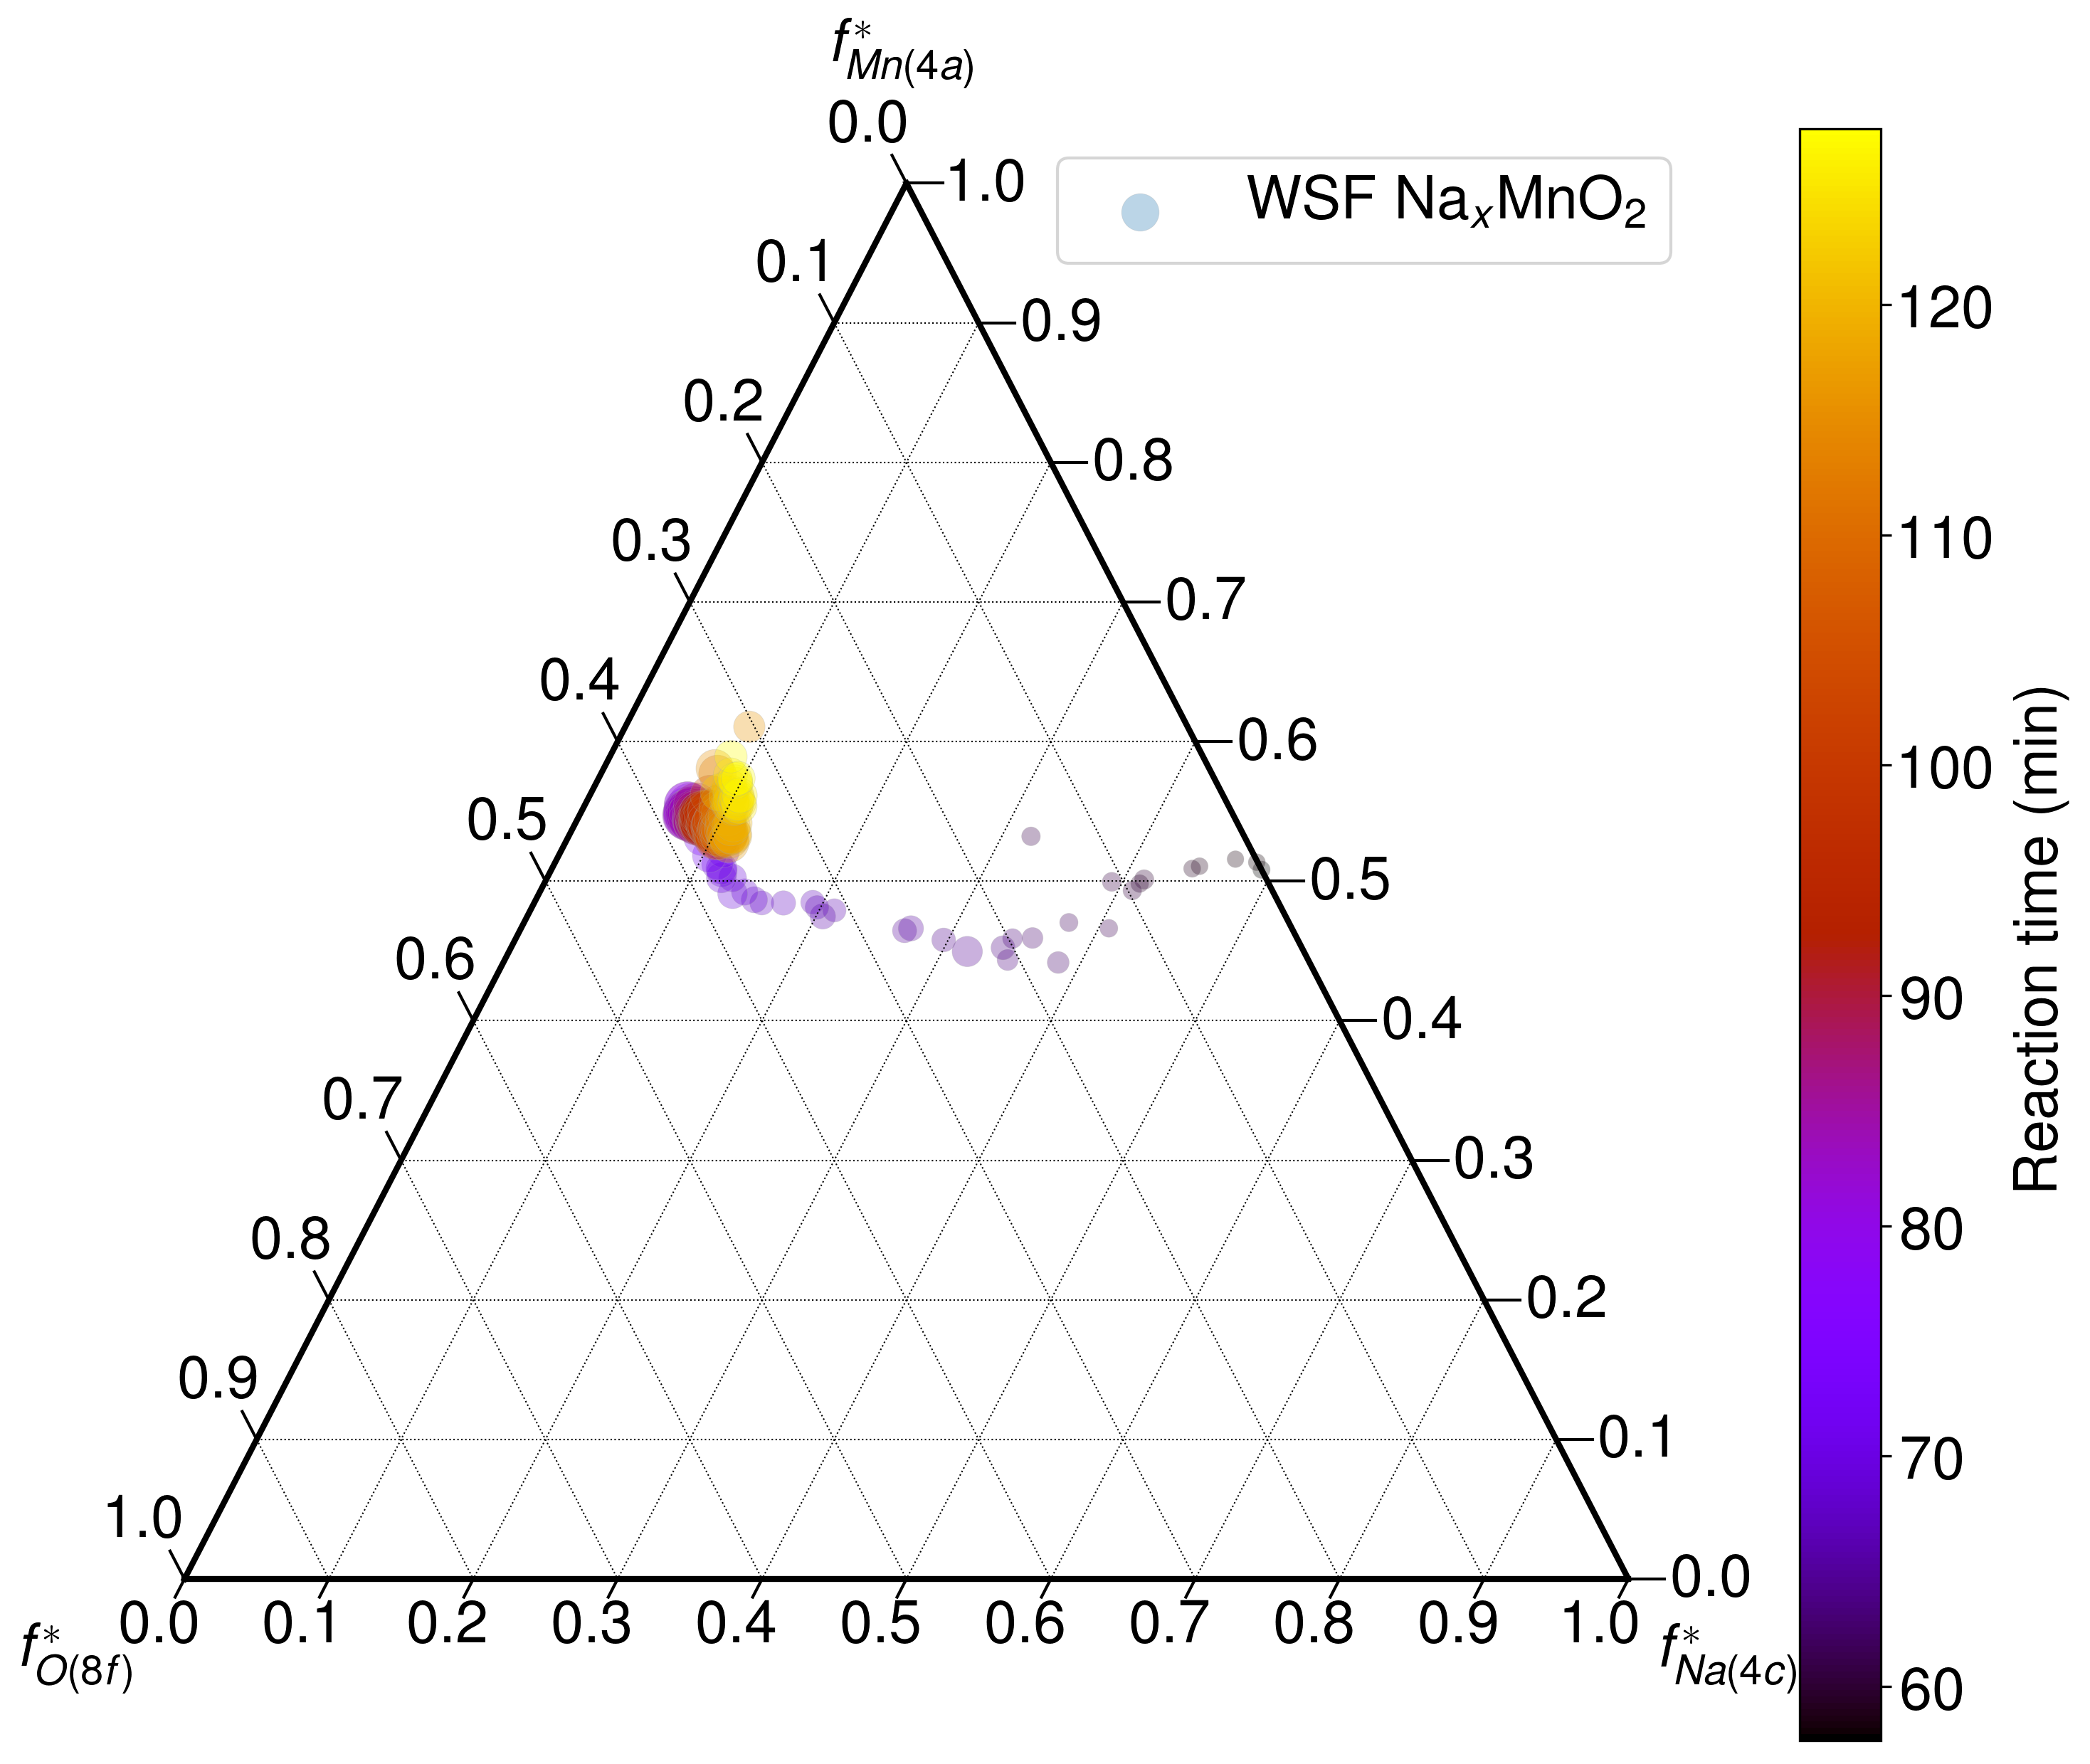

40      34.881154
41      33.597119
42      32.326422
43      33.262480
44      34.335979
          ...    
215    133.412716
216    140.644184
217    138.038035
218    121.380473
219    130.161751
Name: P2-NaxMnO2, Length: 180, dtype: float64

In [79]:
#f* diagrams - P2 NaxMnO2

#marker size
WSF_P210 = WSF_P2[40:220]
area = 3.14*(10*WSF_P210)**2

#fstar_all_points_5beq = fstar_all.to_numpy()
points_P2 = points_P2[40:220]
# colors = np.linspace(0.,60, 209)
colors = np.linspace(57.66,127.66, 180)
fontsize = 20
offset = 0.14
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
# Plot a few different styles with a legend
tax.scatter(points_P2,vmin=min(colors),vmax=max(colors),colormap=plt.cm.gnuplot,colorbar=True,c=colors,cmap=plt.cm.gnuplot,s=area, alpha=0.3, edgecolors='darkgray', cbarlabel='Reaction time (min)', linewidths=0.2, label='WSF Na$_x$MnO$_2$')
#tax.scatter(MnO2, marker='s', color='teal', linewidth=3, label='MnO$_2$')
#tax.scatter(NaMn2O4, marker='s', color='cyan', linewidth=3, label='NaMn$_2$O$_4$')
#tax.scatter(NaMnO2, marker='s', color='lime', linewidth=3, label='NaMnO$_2$')

#tax.scatter(Mn2O3, marker='v', color='green', linewidth=3, label='Mn$_2$O$_3$')
#tax.scatter(NaMn3O8, marker='v', color='lime', linewidth=3, label='NaMn$_3$O$_8$')
#tax.scatter(NaMnO4, marker='v', color='olive', linewidth=3, label='NaMnO$_4$')
#tax.label(8.5, 0.8, 'LiMn$_2$O$_4$', color='orange')

tax.legend()
tax.left_corner_label("$f^{*}_{O(8f)}$", fontsize=fontsize)
tax.top_corner_label("$f^{*}_{Mn(4a)}$", fontsize=fontsize, offset=0.19)
tax.right_corner_label("$f^{*}_{Na(4c)}$", fontsize=fontsize)

#tax.set_title("f* maps for NaMnO$_2$", fontsize=20)
tax.boundary()
tax.gridlines(multiple=0.1, color="black")
tax.ticks(axis='l', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.02)
tax.ticks(axis='b', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.013)
tax.ticks(axis='r', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.025)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.show()
area
# tax.savefig('/Applications/TeX/Documents/Na2CO3_AssistedMetathesis/fstar_NaxMnO2.png', dpi=300)

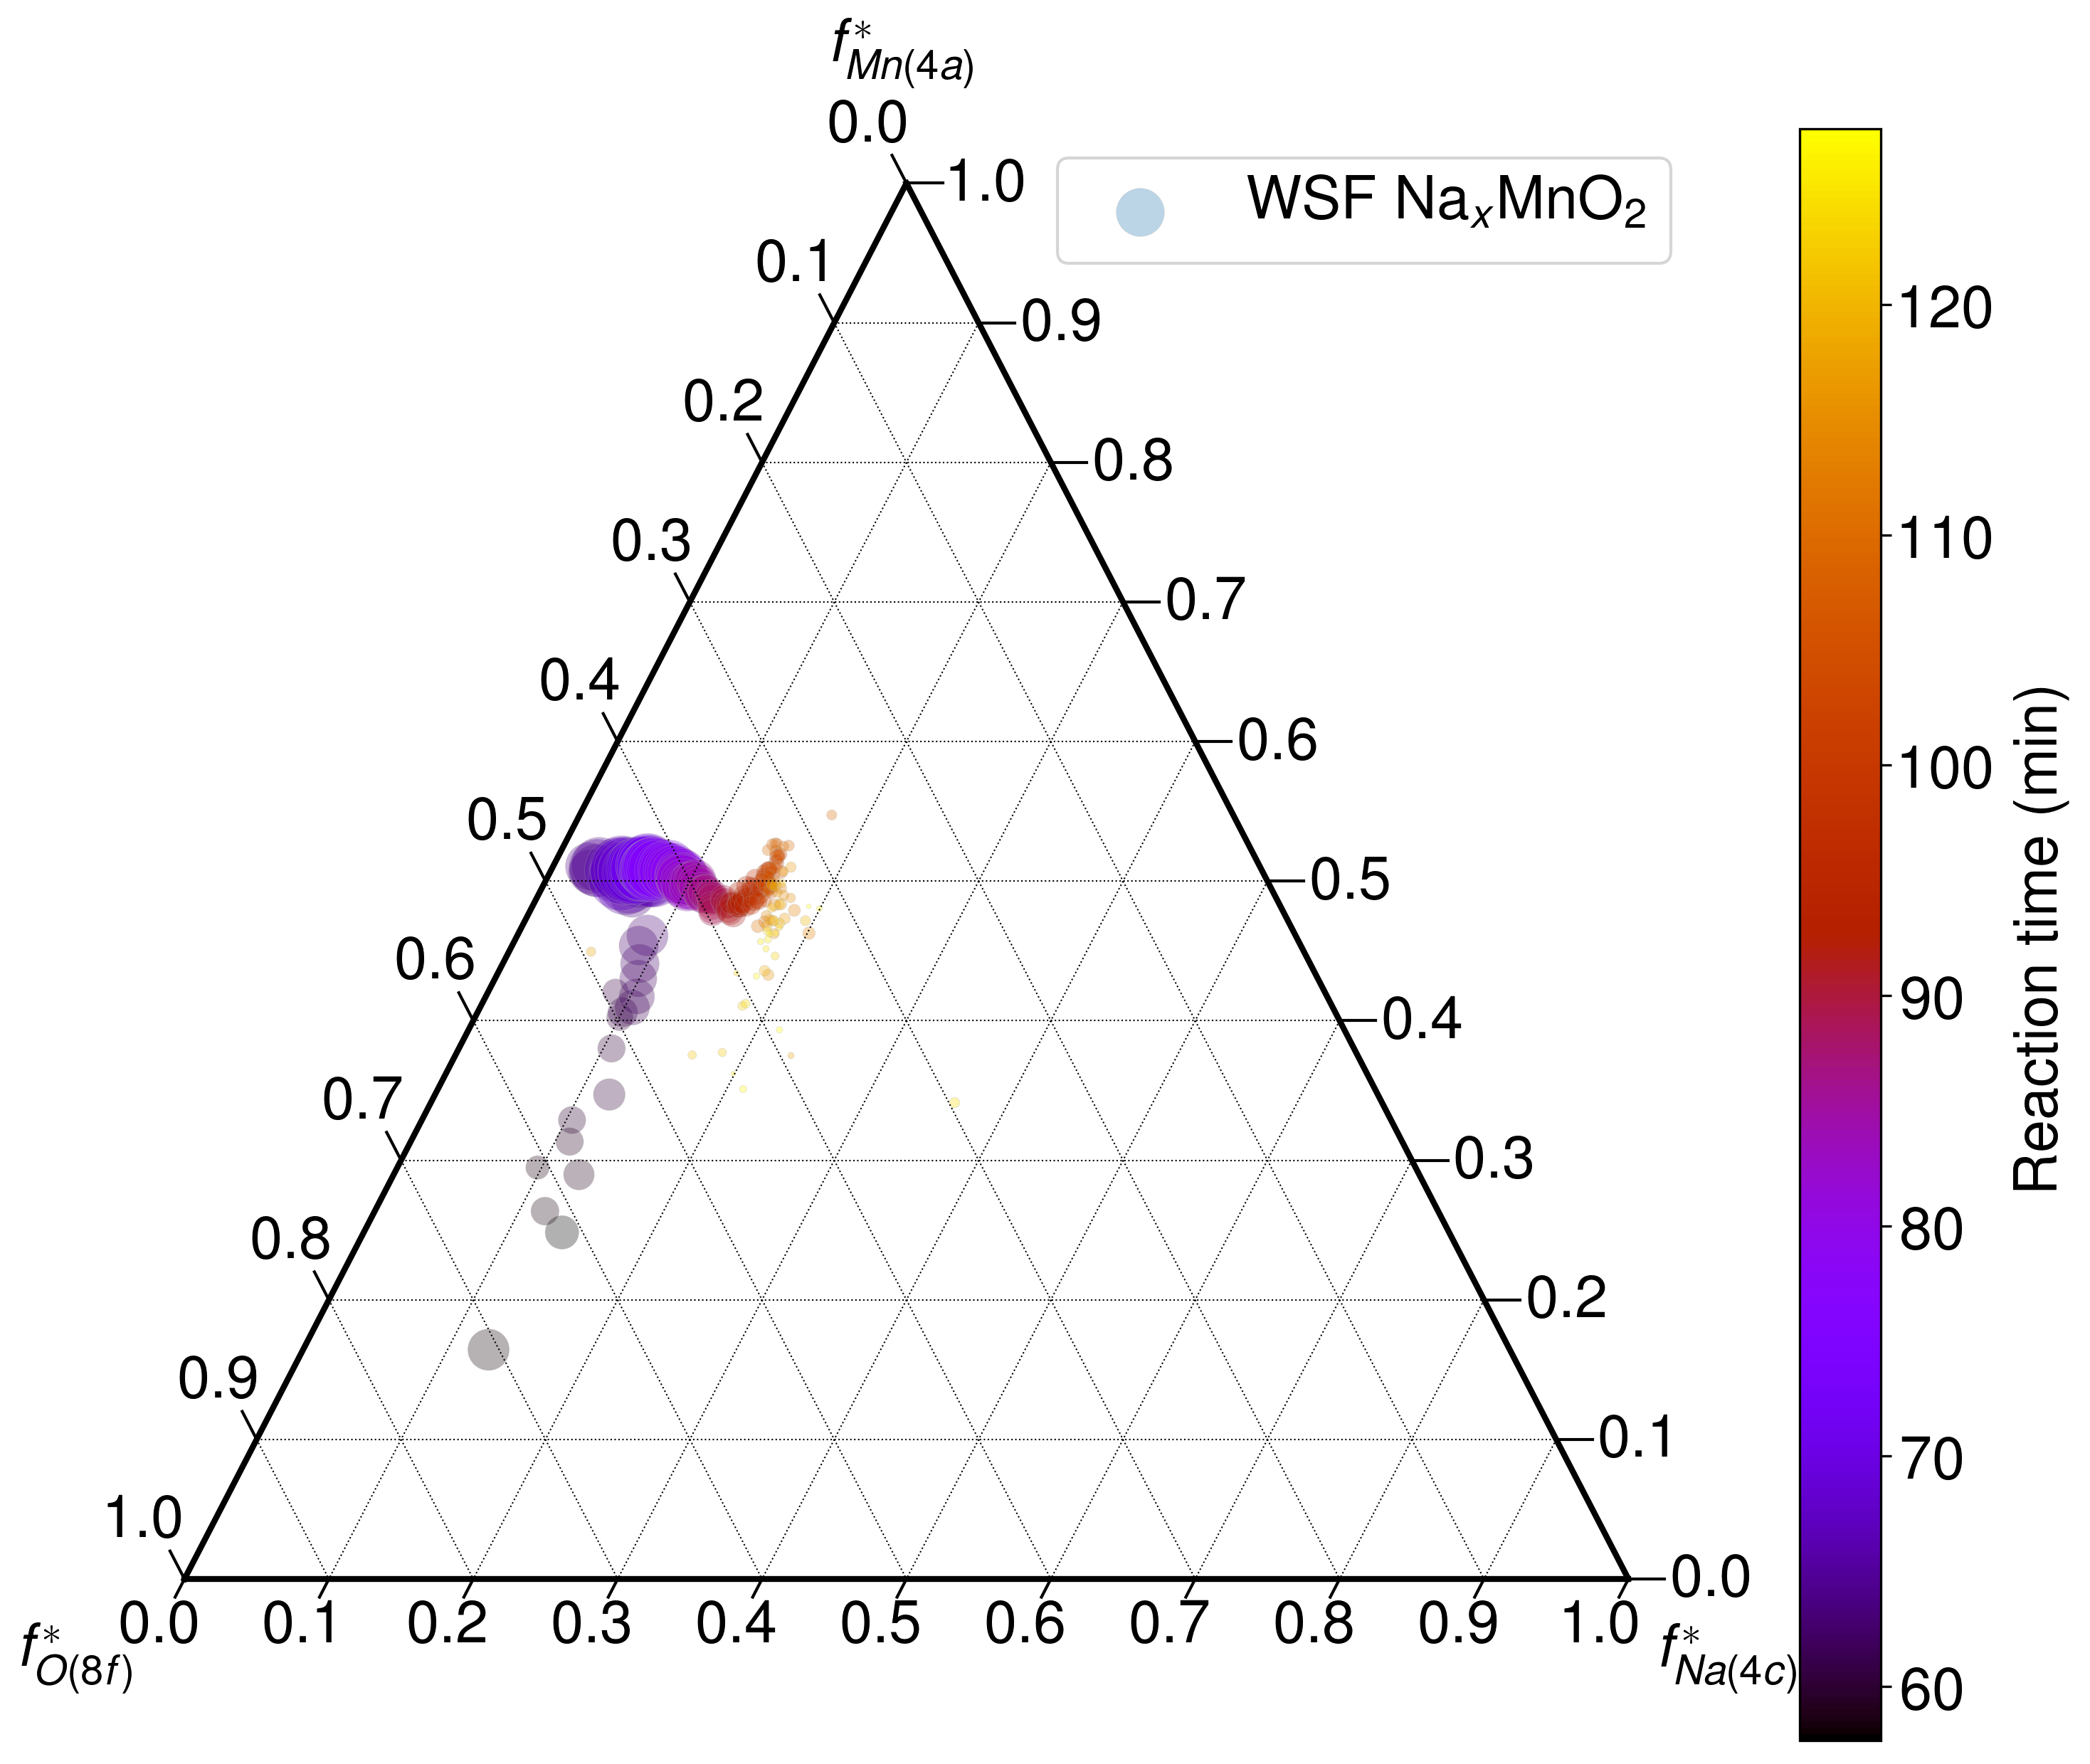

0      128.605250
1      194.901822
2       90.009094
3       63.749953
4      107.810327
          ...    
215      3.733001
216      4.817030
217      5.888872
218      4.858223
219      2.514606
Name: P3-NaMnO2, Length: 220, dtype: float64

In [80]:
#f* diagrams - P3-NaxMnO2

#marker size
WSF_P310 = WSF_P3
area = 3.14*(5*WSF_P310)**2

#fstar_all_points_5beq = fstar_all.to_numpy()
points = points_P3
# colors = np.linspace(0.,60, 209)
colors = np.linspace(57.66,127.66, 220)
fontsize = 20
offset = 0.14
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
# Plot a few different styles with a legend
tax.scatter(points_P3,vmin=min(colors),vmax=max(colors),colormap=plt.cm.gnuplot,colorbar=True,c=colors,cmap=plt.cm.gnuplot,s=area, alpha=0.3, edgecolors='darkgray', cbarlabel='Reaction time (min)', linewidths=0.2, label='WSF Na$_x$MnO$_2$')
#tax.scatter(MnO2, marker='s', color='teal', linewidth=3, label='MnO$_2$')
#tax.scatter(NaMn2O4, marker='s', color='cyan', linewidth=3, label='NaMn$_2$O$_4$')
#tax.scatter(NaMnO2, marker='s', color='lime', linewidth=3, label='NaMnO$_2$')

#tax.scatter(Mn2O3, marker='v', color='green', linewidth=3, label='Mn$_2$O$_3$')
#tax.scatter(NaMn3O8, marker='v', color='lime', linewidth=3, label='NaMn$_3$O$_8$')
#tax.scatter(NaMnO4, marker='v', color='olive', linewidth=3, label='NaMnO$_4$')
#tax.label(8.5, 0.8, 'LiMn$_2$O$_4$', color='orange')

tax.legend()
tax.left_corner_label("$f^{*}_{O(8f)}$", fontsize=fontsize)
tax.top_corner_label("$f^{*}_{Mn(4a)}$", fontsize=fontsize, offset=0.19)
tax.right_corner_label("$f^{*}_{Na(4c)}$", fontsize=fontsize)

#tax.set_title("f* maps for NaMnO$_2$", fontsize=20)
tax.boundary()
tax.gridlines(multiple=0.1, color="black")
tax.ticks(axis='l', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.02)
tax.ticks(axis='b', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.013)
tax.ticks(axis='r', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.025)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.show()
area
# tax.savefig('/Applications/TeX/Documents/Na2CO3_AssistedMetathesis/fstar_NaxMnO2.png', dpi=300)

# Let's filter out only the most signficant data points by the relative WSF values:

First, P3-NaxMnO2: Filter out by initial time and significance limit:

In [4]:
## CRITERIA TO ADJUST:

limit = 0.2
timelimit= 60

# FILTERING:
dataP3 = pd.concat([P3_fstar, WSF_P3], axis=1)
dataP3['time'] = np.linspace(57.66,127.66, 220)
dataP3 = dataP3.loc[(dataP3['time'] > timelimit)]
dataP3['relWSF'] = (dataP3['P3-NaMnO2']-dataP3['P3-NaMnO2'].min())/(dataP3['P3-NaMnO2'].max()-dataP3['P3-NaMnO2'].min())
dataP3 = dataP3.loc[(dataP3['relWSF'] > limit) & (dataP3['time'] > timelimit)]
dataP3.reset_index(drop=True, inplace=True)
dataP3

,0,1,2,P3-NaMnO2,time,relWSF
0,0.105708,0.380116,0.514177,1.056458,60.217078,0.365253
1,0.100365,0.402218,0.497417,1.009529,60.536712,0.345718
2,0.088239,0.420615,0.491147,0.992875,60.856347,0.338786
3,0.100461,0.406051,0.493488,1.133600,61.175982,0.397363
4,0.105329,0.409351,0.485320,1.330009,61.495616,0.479119
5,0.104593,0.417271,0.478136,1.355866,61.815251,0.489882
6,0.099236,0.430090,0.470674,1.415726,62.134886,0.514799
7,0.094949,0.440833,0.464217,1.474233,62.454521,0.539153
8,0.087748,0.453693,0.458559,1.499156,62.774155,0.549527
9,0.090124,0.460965,0.448911,1.576154,63.093790,0.581577


In [2]:
#Weighted Scale Factor of filtered data - P3
plt.figure()
plt.plot(dataP3['time'],dataP3['relWSF'])

NameError: name 'dataP3' is not defined

<Figure size 432x288 with 0 Axes>

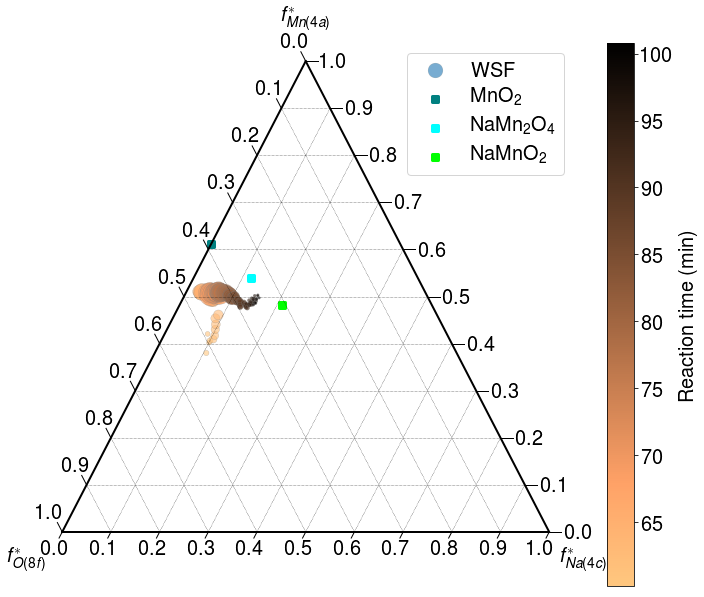

0      29.619431
1      25.844946
2      24.586911
3      36.593092
4      59.099436
         ...    
120     7.242706
121     9.144500
122     7.945798
123     8.164776
124     7.216251
Name: P3-NaMnO2, Length: 125, dtype: float64

In [6]:
#f* diagrams - Filtered P3-NaxMnO2

#marker size
WSF_P310 = dataP3['P3-NaMnO2']
area = 3.14*(2*WSF_P310)**3

#fstar_all_points_5beq = fstar_all.to_numpy()

P3_fstar = pd.concat([dataP3[0], dataP3[1], dataP3[2]], axis=1, sort=False)
points_P3 = P3_fstar.to_numpy()


points = points_P3
# colors = np.linspace(0.,60, 209)
colors = dataP3['time']
fontsize = 20
offset = 0.14
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
# Plot a few different styles with a legend
tax.scatter(points_P3,vmin=min(colors),vmax=max(colors),colormap=plt.cm.copper_r,colorbar=True,c=colors,cmap=plt.cm.copper_r,s=area, alpha=0.6, edgecolors='grey', cbarlabel='Reaction time (min)', linewidths=0.3, label='WSF')
tax.scatter(MnO2, marker='s', color='teal', linewidth=3, label='MnO$_2$')
tax.scatter(NaMn2O4, marker='s', color='cyan', linewidth=3, label='NaMn$_2$O$_4$')
tax.scatter(NaMnO2, marker='s', color='lime', linewidth=3, label='NaMnO$_2$')

#tax.scatter(Mn2O3, marker='v', color='green', linewidth=3, label='Mn$_2$O$_3$')
#tax.scatter(NaMn3O8, marker='v', color='lime', linewidth=3, label='NaMn$_3$O$_8$')
#tax.scatter(NaMnO4, marker='v', color='olive', linewidth=3, label='NaMnO$_4$')
#tax.label(8.5, 0.8, 'LiMn$_2$O$_4$', color='orange')

tax.legend()
tax.left_corner_label("$f^{*}_{O(8f)}$", fontsize=fontsize)
tax.top_corner_label("$f^{*}_{Mn(4a)}$", fontsize=fontsize, offset=0.19)
tax.right_corner_label("$f^{*}_{Na(4c)}$", fontsize=fontsize)

#tax.set_title("f* maps for NaMnO$_2$", fontsize=20)
tax.boundary()
tax.gridlines(multiple=0.1, color="black")
tax.ticks(axis='l', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.02)
tax.ticks(axis='b', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.013)
tax.ticks(axis='r', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.025)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.show()
area
# tax.savefig('/Applications/TeX/Documents/Na2CO3_AssistedMetathesis/fstar_NaxMnO2.png', dpi=300)

# Lets do it with P2:

Filter out by initial time and significance limit:

In [30]:
## CRITERIA TO ADJUST:
limit = 0.1
timelimit= 80

### FILTERING
dataP2 = pd.concat([P2_fstar, WSF_P2], axis=1)
dataP2['time'] = np.linspace(57.66,127.66, 220)
dataP2 = dataP2.loc[(dataP2['time'] > timelimit)]
dataP2['relWSF'] = (dataP2['P2-NaxMnO2']-dataP2['P2-NaxMnO2'].min())/(dataP2['P2-NaxMnO2'].max()-dataP2['P2-NaxMnO2'].min())
dataP2 = dataP2.loc[(dataP2['relWSF'] > limit) & (dataP2['time'] > timelimit)]
dataP2.reset_index(drop=True, inplace=True)
dataP2

,0,1,2,P2-NaxMnO2,time,relWSF
0,0.120686,0.502334,0.376980,0.575090,80.354064,0.103064
1,0.118894,0.506603,0.374503,0.579928,80.673699,0.114403
2,0.117528,0.508886,0.373586,0.597149,80.993333,0.154762
3,0.112992,0.512212,0.374796,0.602258,81.312968,0.166736
4,0.112466,0.521205,0.366329,0.614558,81.632603,0.195562
5,0.104380,0.518382,0.377238,0.650422,81.952237,0.279617
6,0.106309,0.527686,0.366004,0.653019,82.271872,0.285703
7,0.103650,0.530515,0.365835,0.659385,82.591507,0.300622
8,0.099077,0.533128,0.367795,0.672761,82.911142,0.331971
9,0.092880,0.531494,0.375626,0.710825,83.230776,0.421181


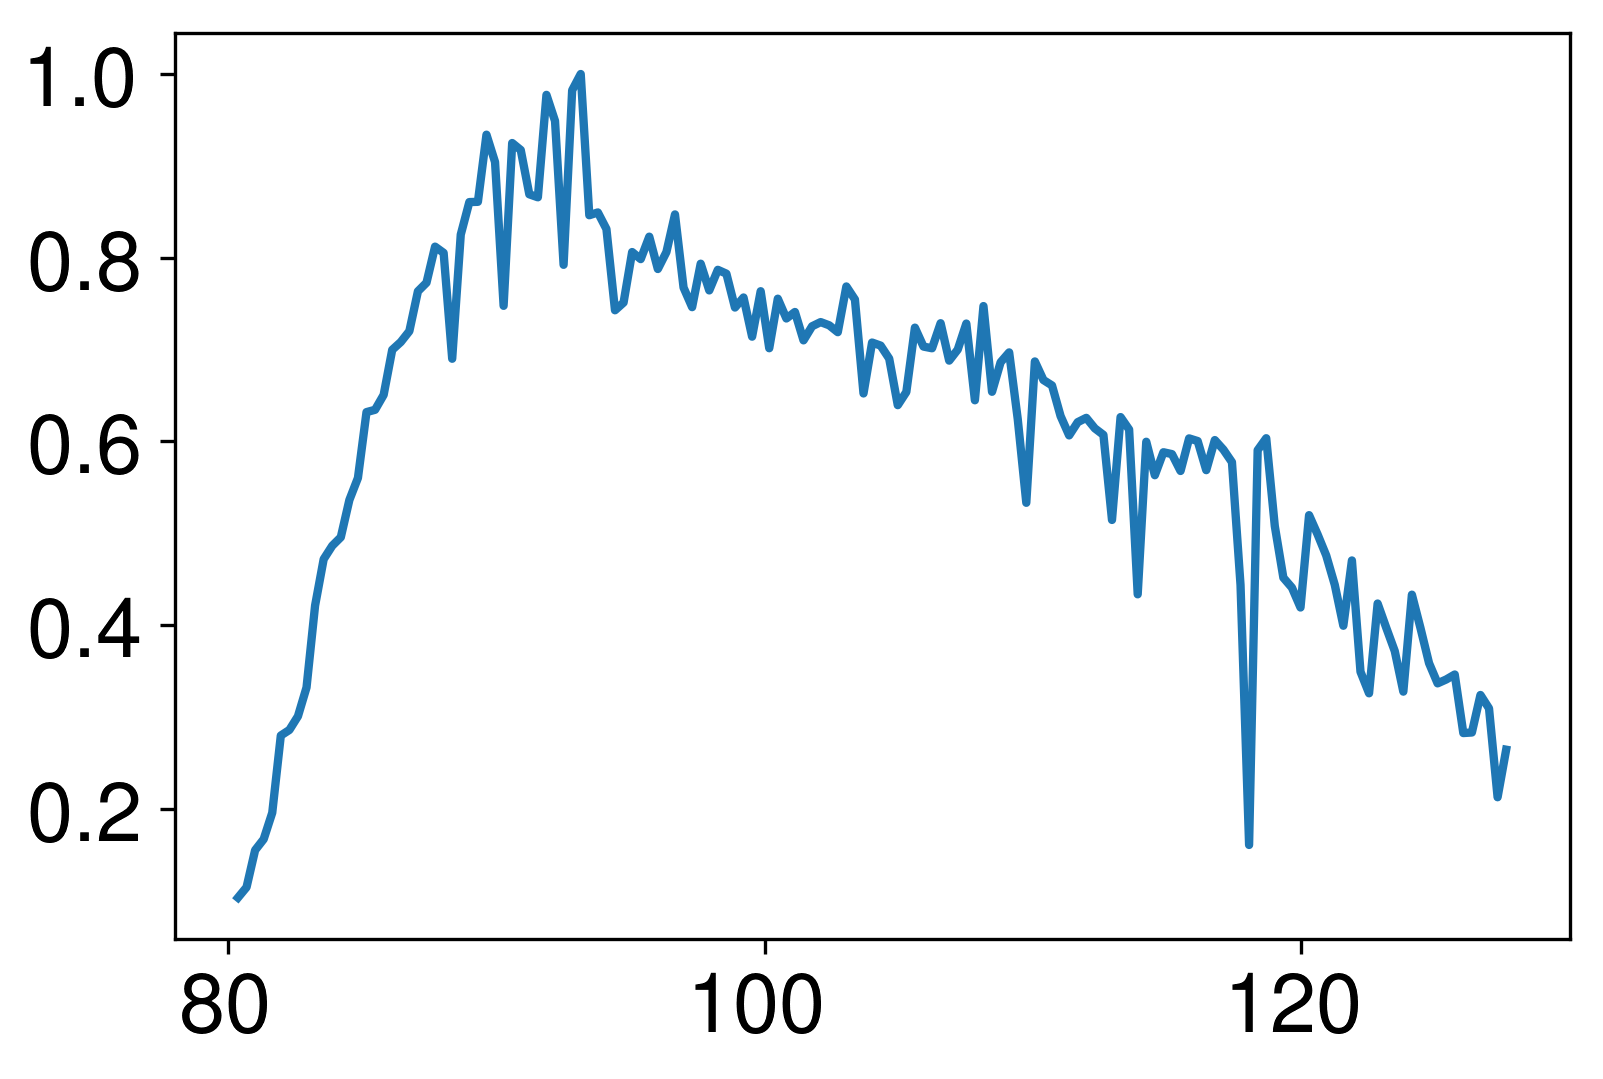

In [31]:
plt.figure()
plt.plot(dataP2['time'],dataP2['relWSF'])

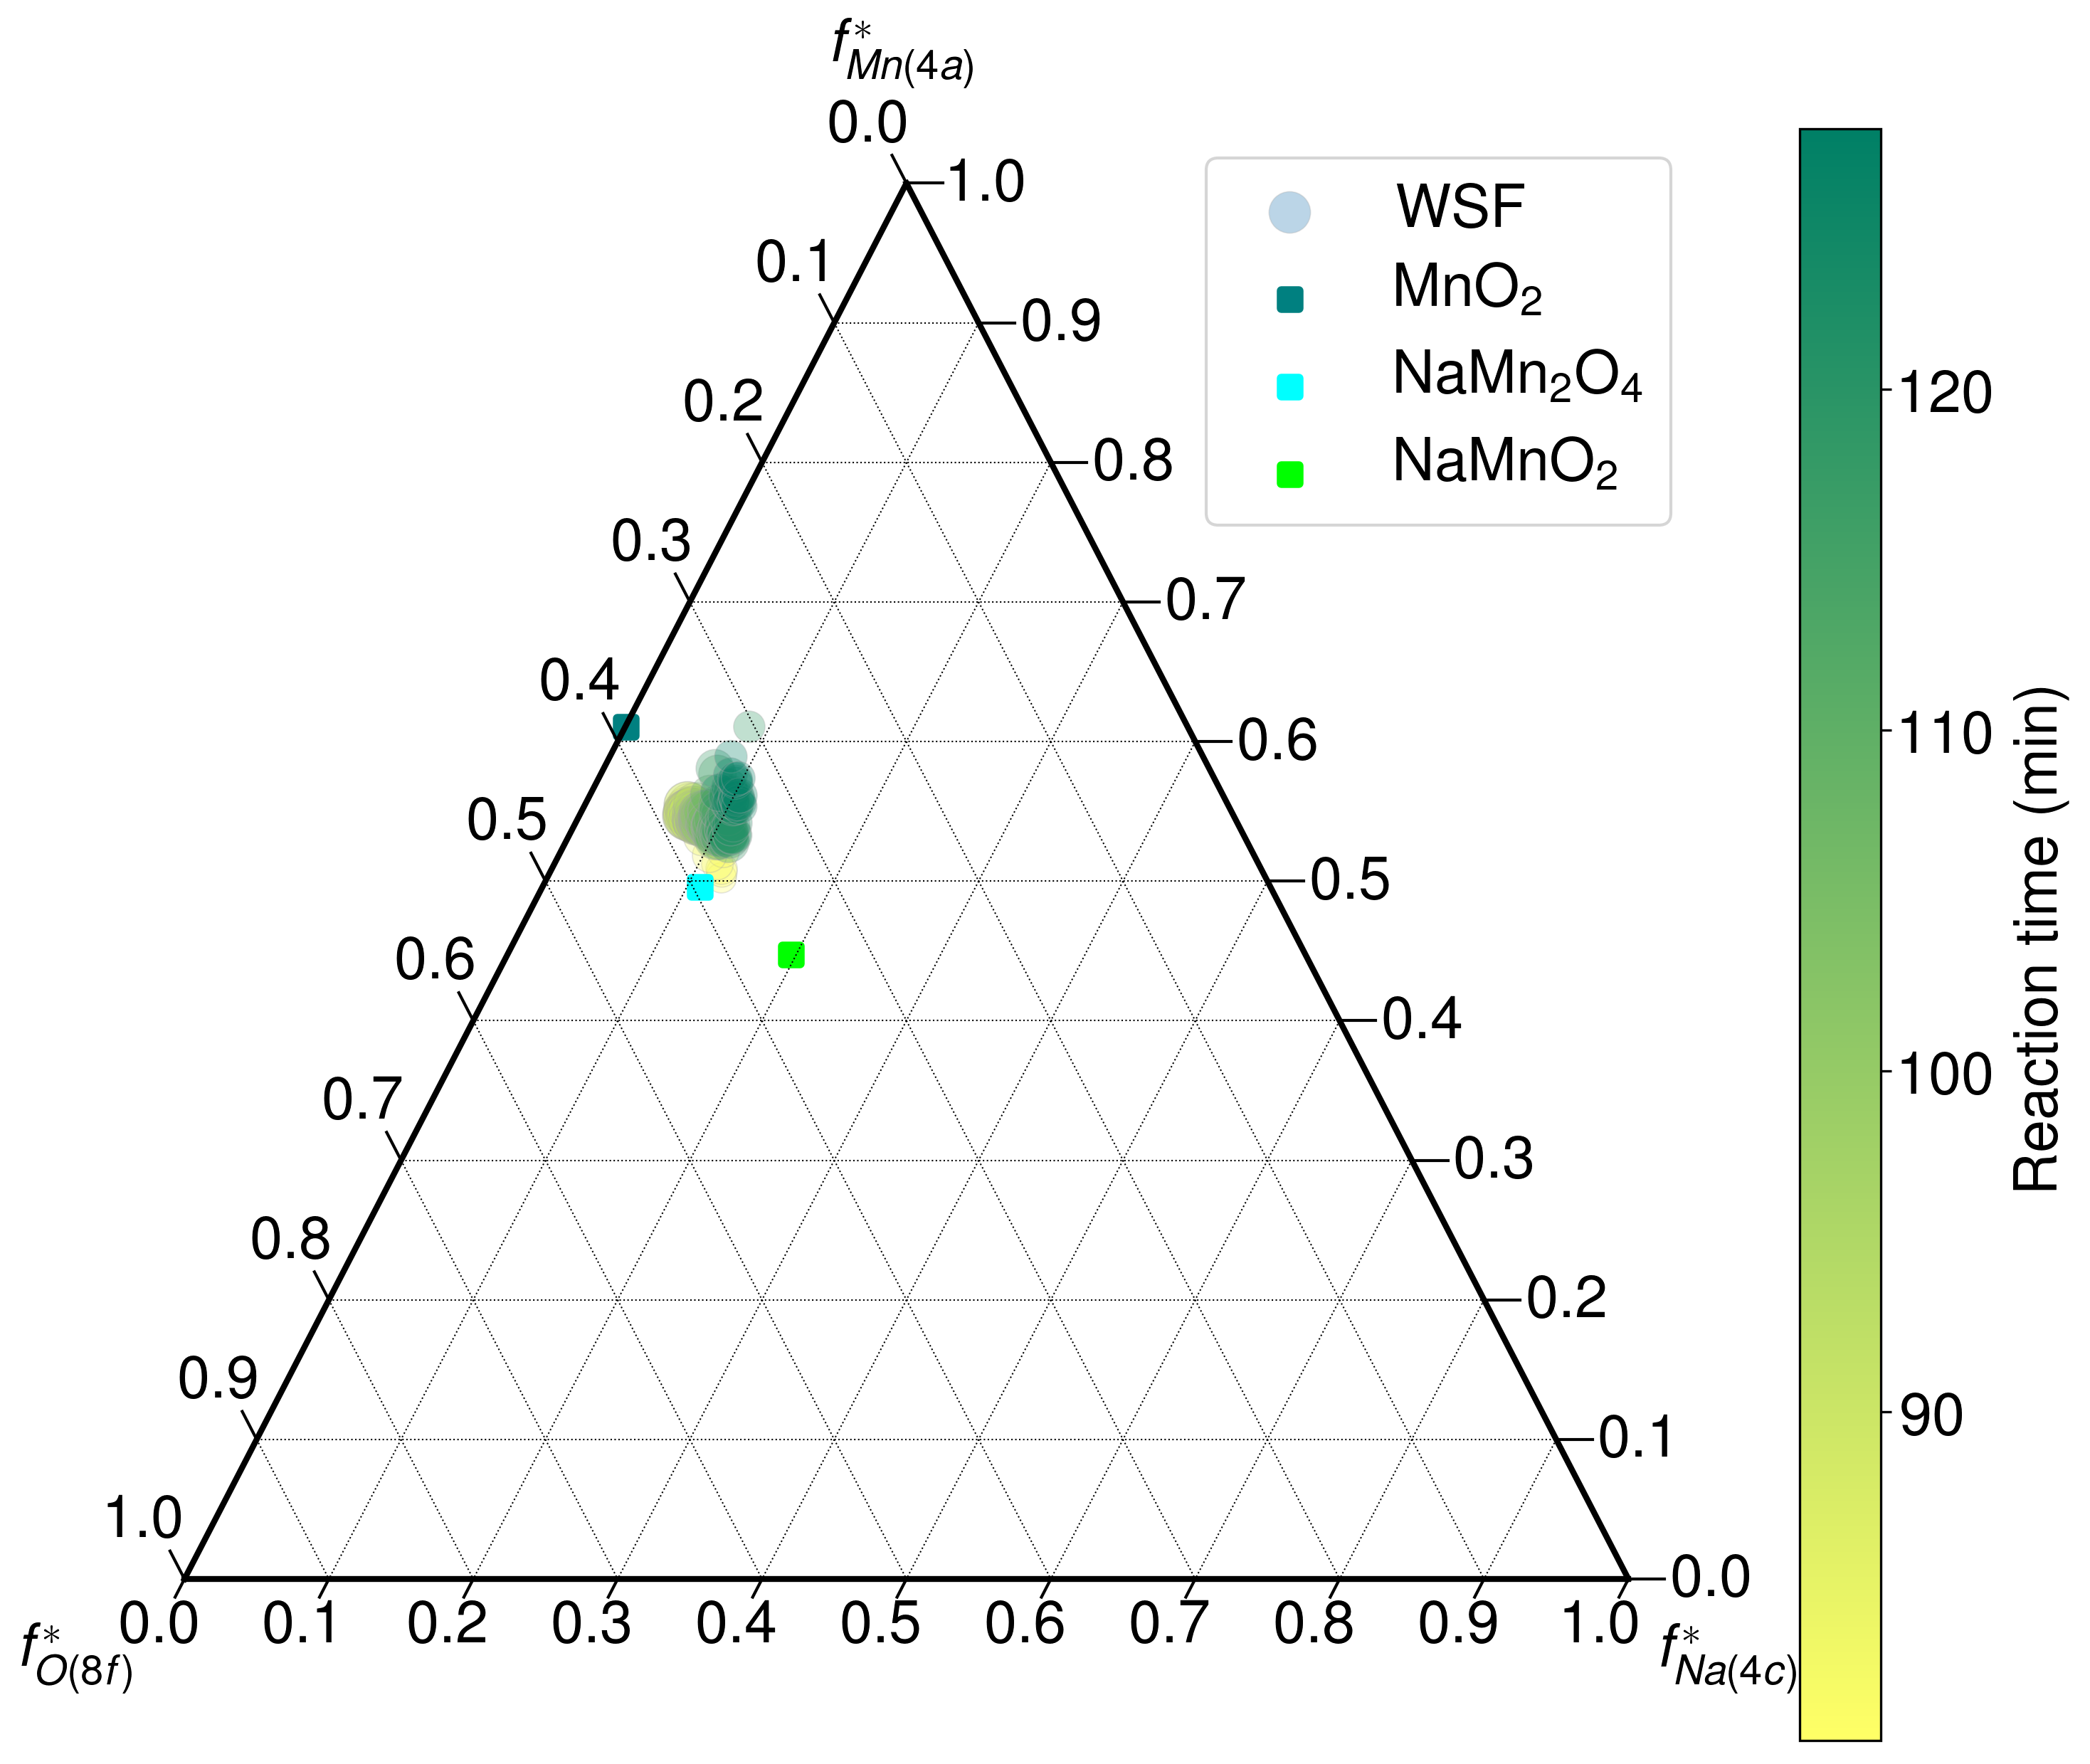

0      103.848799
1      105.603439
2      111.968197
3      113.892385
4      118.591844
          ...    
144    133.412716
145    140.644184
146    138.038035
147    121.380473
148    130.161751
Name: P2-NaxMnO2, Length: 149, dtype: float64

In [32]:
#f* diagrams - P2

#marker size
WSF_P210 = dataP2['P2-NaxMnO2']
area = 3.14*(10*WSF_P210)**2

P2_fstar = pd.concat([dataP2[0], dataP2[1], dataP2[2]], axis=1, sort=False)
points_P2 = P2_fstar.to_numpy()
colors = dataP2['time']


fontsize = 20
offset = 0.14
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
# Plot a few different styles with a legend
tax.scatter(points_P2,vmin=min(colors),vmax=max(colors),colormap=plt.cm.summer_r,colorbar=True,c=colors,cmap=plt.cm.summer_r,s=area, alpha=0.3, edgecolors='darkgray', cbarlabel='Reaction time (min)', linewidths=0.4, label='WSF')
tax.scatter(MnO2, marker='s', color='teal', linewidth=3, label='MnO$_2$')
tax.scatter(NaMn2O4, marker='s', color='cyan', linewidth=3, label='NaMn$_2$O$_4$')
tax.scatter(NaMnO2, marker='s', color='lime', linewidth=3, label='NaMnO$_2$')

#tax.scatter(Mn2O3, marker='v', color='green', linewidth=3, label='Mn$_2$O$_3$')
#tax.scatter(NaMn3O8, marker='v', color='lime', linewidth=3, label='NaMn$_3$O$_8$')
#tax.scatter(NaMnO4, marker='v', color='olive', linewidth=3, label='NaMnO$_4$')
#tax.label(8.5, 0.8, 'LiMn$_2$O$_4$', color='orange')

tax.legend()
tax.left_corner_label("$f^{*}_{O(8f)}$", fontsize=fontsize)
tax.top_corner_label("$f^{*}_{Mn(4a)}$", fontsize=fontsize, offset=0.19)
tax.right_corner_label("$f^{*}_{Na(4c)}$", fontsize=fontsize)

#tax.set_title("f* maps for NaMnO$_2$", fontsize=20)
tax.boundary()
tax.gridlines(multiple=0.1, color="black")
tax.ticks(axis='l', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.02)
tax.ticks(axis='b', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.013)
tax.ticks(axis='r', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=fontsize, offset=0.025)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.show()
area
# tax.savefig('/Applications/TeX/Documents/Na2CO3_AssistedMetathesis/fstar_NaxMnO2.png', dpi=300)

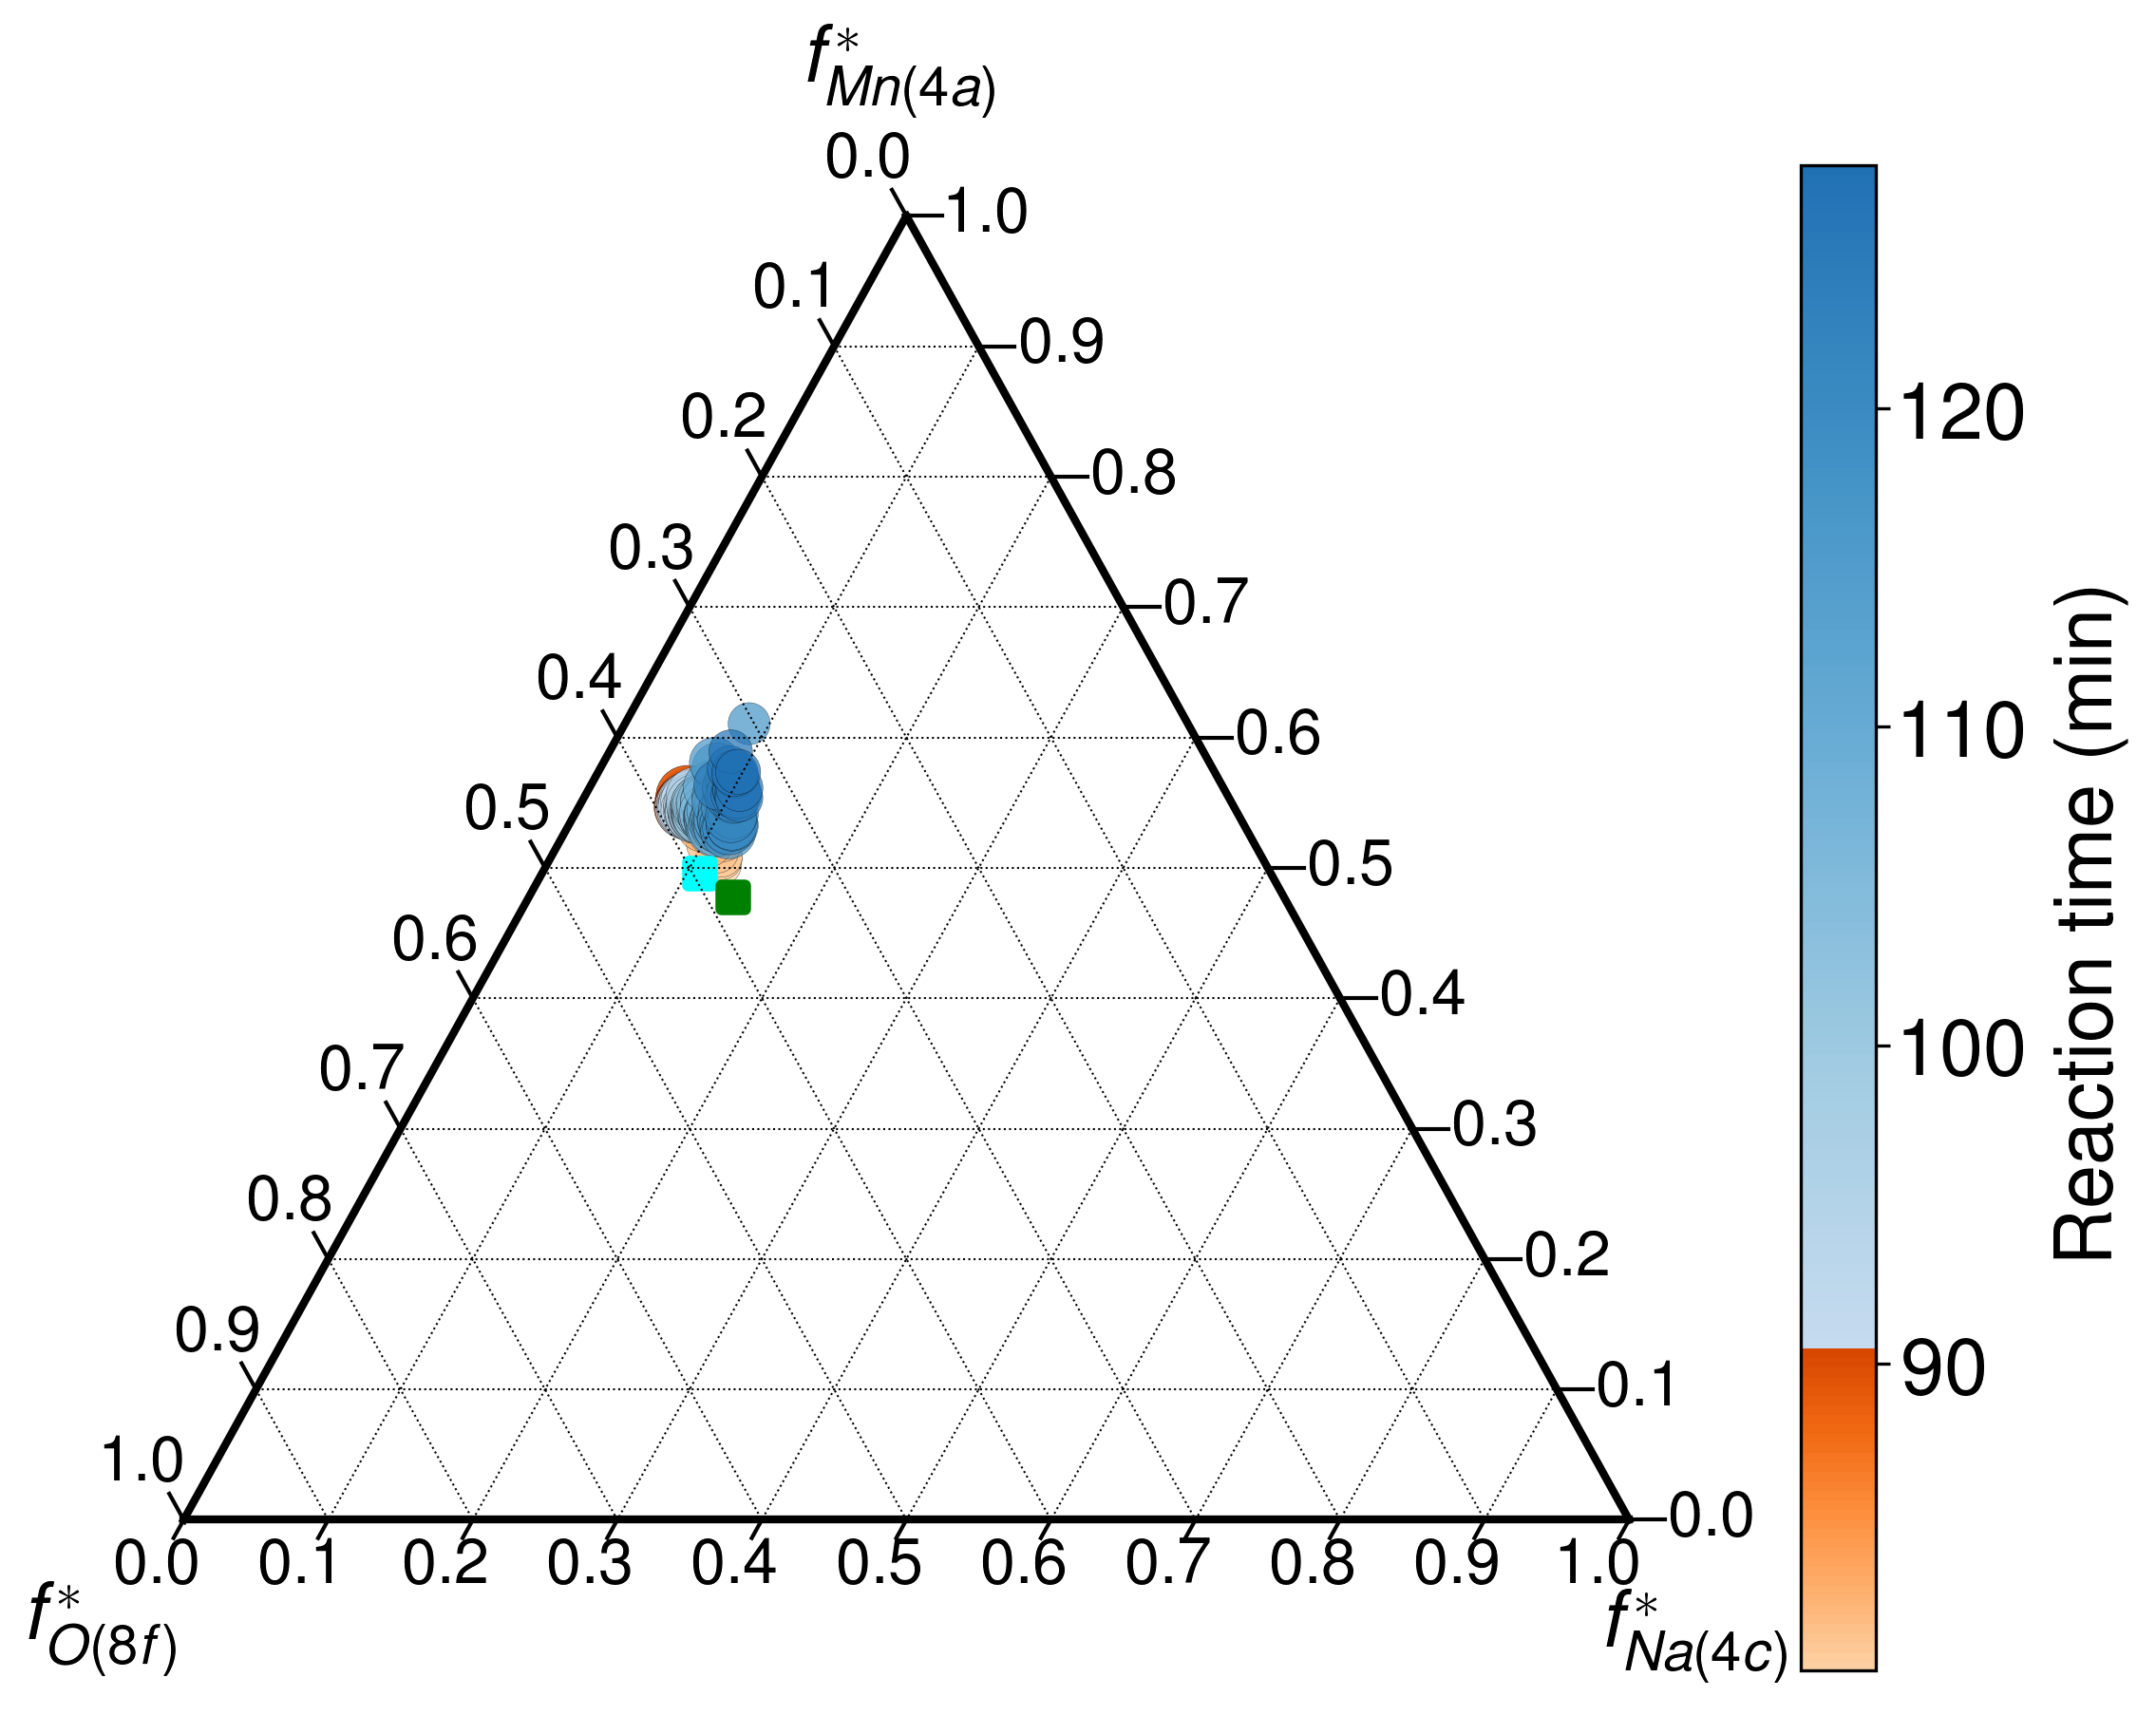

In [33]:
#f* diagrams - P2 with trajectories
colors = np.linspace(80,127.66, 209)
middle = cm.get_cmap('Oranges', 256)
top = cm.get_cmap('Purples', 256)
bottom = cm.get_cmap('Blues', 256)

newcolors = np.vstack((middle(np.linspace(0.25, 0.75, 34)), bottom(np.linspace(0.25, 0.75, 125))))
newcmp = ListedColormap(newcolors, name='Test')
colors = dataP2['time']

#marker size
area = 3.14*(10*WSF_P210)**2
#'#ffcc5c'

# colors = np.linspace(0.,60, 209)

#cmap = mpl.colors.ListedColormap(['#4040a1', '#ffef96', '#ff6f69'])
#bounds = [57.66, 64, 85, 127.66]
#norm = mpl.colors.BoundaryNorm(bounds, newcmp.N)

#cb_kwargs = {"boundaries" : bounds, "spacing": "proportional"}
dots = 'Black'
mark= 'D'
fontsize = 20
offset = 0.14
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(9, 7)
#ax= figure.add_axes([0.95, 0.15, 0.04, 0.75])
#cb2 = mpl.colorbar.ColorbarBase(ax, cmap=newcmp,norm=norm, ticks=bounds,spacing='proportional', orientation='vertical')
#cb2.set_label('Reaction time (min)')
#cb = tax.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap)
# Plot a few different styles with a legend
tax.scatter(points_P2, c=colors, vmin=min(colors),vmax=max(colors),colormap=newcmp, s=area, alpha=0.7, edgecolors='black',colorbar=True, cbarlabel='Reaction time (min)', cmap=newcmp, linewidths=0.1, label='WSF P2-Na$_x$MnO$_2$')
# tax.scatter(MnO2, marker='s', color='teal', linewidth=3, label='MnO$_2$')
# tax.scatter(NaMn2O4, marker='s', color='cyan', linewidth=3, label='NaMn$_2$O$_4$')
# tax.scatter(NaMnO2, marker='s', color='lime', linewidth=3, label='NaMnO$_2$')
# tax.plot(points_CS, color='red')
# tax.plot(points_CV, color='red')
#tax.scatter(Mn2O3, marker='v', color='green', linewidth=3, label='Mn$_2$O$_3$')
#tax.scatter(NaMn3O8, marker='v', color='lime', linewidth=3, label='NaMn$_3$O$_8$')
#tax.scatter(NaMnO4, marker='v', color='olive', linewidth=3, label='NaMnO$_4$')
#tax.label(8.5, 0.8, 'LiMn$_2$O$_4$', color='orange')

tax.scatter(NaMn2O4, marker='s', color='cyan', linewidth=3, label='NaMn$_2$O$_4$')
tax.scatter(Na67MnO2, marker='s', color='green', linewidth=3, label='NaMn$_2$O$_4$')
### Cation swapping:
numpoints=5
Na_start=0.25
Na_stop=0.1
Mn_start=0.75
Mn_stop=0.51
Mn_Na_start = 0.0
Mn_Na_stop=0.24
Na=np.linspace(Na_start,Na_stop,numpoints)
Mn=np.linspace(Mn_start,Mn_stop,numpoints)
Mn_Na = np.linspace(Mn_Na_start,Mn_Na_stop,numpoints)
O=np.linspace(1,1,51)
fNa=(Na*4*AFFNa)+(Mn_Na*4*AFFMn)
fMn=Mn*AFFMn*4
fO=8*AFFO*O

fs_swap=np.zeros([len(fNa),3])
for ii in range(0,len(fNa)):
    fs_swap[ii,0] = fNa[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_swap[ii,1] = fMn[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_swap[ii,2] = fO[ii]/(fNa[ii]+fMn[ii]+fO[ii])
#tax.scatter(fs_swap, color=dots, marker=mark)
#tax.plot(fs_swap, color=dots, linewidth=3)


### cation vacancies
numpoints=5
Na_start=0.25
Na_stop=0.5
Mn_start=0.75
Mn_stop=1.0
Mn_Na_start = 0.0
Mn_Na_stop=0.0
Na=np.linspace(Na_start,Na_stop,numpoints)
Mn=np.linspace(Mn_start,Mn_stop,numpoints)
Mn_Na = np.linspace(Mn_Na_start,Mn_Na_stop,numpoints)
O=np.linspace(1,1,51)
fNa=(Na*4*AFFNa)+(Mn_Na*4*AFFMn)
fMn=Mn*AFFMn*4
fO=8*AFFO*O


fs_vac=np.zeros([len(fNa),3])
for ii in range(0,len(fNa)):
    fs_vac[ii,0] = fNa[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_vac[ii,1] = fMn[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_vac[ii,2] = fO[ii]/(fNa[ii]+fMn[ii]+fO[ii])
#tax.scatter(fs_vac, color=dots, marker=mark)
#tax.plot(fs_vac, color=dots, linewidth=3)


### Na vacancies
numpoints=5
Na_start=0.5
Na_stop=1.0
Mn_start=1.0
Mn_stop=1.0
Mn_Na_start = 0.0
Mn_Na_stop=0.0
Na=np.linspace(Na_start,Na_stop,numpoints)
Mn=np.linspace(Mn_start,Mn_stop,numpoints)
Mn_Na = np.linspace(Mn_Na_start,Mn_Na_stop,numpoints)
O=np.linspace(1,1,51)
fNa=(Na*4*AFFNa)+(Mn_Na*4*AFFMn)
fMn=Mn*AFFMn*4
fO=8*AFFO*O


fs_Navac=np.zeros([len(fNa),3])
for ii in range(0,len(fNa)):
    fs_Navac[ii,0] = fNa[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_Navac[ii,1] = fMn[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_Navac[ii,2] = fO[ii]/(fNa[ii]+fMn[ii]+fO[ii])
#tax.scatter(fs_Navac, color=dots, marker=mark)
#tax.plot(fs_Navac, color=dots, linewidth=3)



#tax.legend()
tax.left_corner_label("$f^{*}_{O(8f)}$", fontsize=20, offset=0.01)
tax.top_corner_label("$f^{*}_{Mn(4a)}$", fontsize=20)
tax.right_corner_label("$f^{*}_{Na(4c)}$", fontsize=20, offset=0)

#tax.set_title("f* maps for NaMnO$_2$", fontsize=20)
tax.boundary()
tax.gridlines(multiple=0.1, color="black")
tax.ticks(axis='l', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=16, offset=0.02)
tax.ticks(axis='b', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=16, offset=0.014
         )
tax.ticks(axis='r', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=16, offset=0.025)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.show()
tax.savefig('/Applications/TeX/Documents/Na2CO3_AssistedMetathesis/fstar_trajectories_P2.png', dpi=300)

In [8]:
points_P3[::-1]

array([[0.15567945, 0.49727576, 0.34704479],
       [0.15428992, 0.48580434, 0.35990574],
       [0.15186382, 0.49465201, 0.35348416],
       [0.15125796, 0.48268445, 0.36605759],
       [0.15054161, 0.50166554, 0.34779286],
       [0.15225426, 0.48694694, 0.36079881],
       [0.15018705, 0.50310091, 0.34671203],
       [0.15310184, 0.49023092, 0.35666724],
       [0.15132482, 0.49431898, 0.35435619],
       [0.14554798, 0.49337594, 0.36107608],
       [0.14703984, 0.49540052, 0.35755965],
       [0.14441101, 0.50174279, 0.3538462 ],
       [0.14877875, 0.48936471, 0.36185655],
       [0.15095376, 0.4861409 , 0.36290534],
       [0.14490728, 0.48811589, 0.36697683],
       [0.14105499, 0.49630634, 0.36263867],
       [0.14511729, 0.49536233, 0.35952039],
       [0.14727319, 0.48245919, 0.37026763],
       [0.14316633, 0.48452884, 0.37230483],
       [0.14299517, 0.48872152, 0.36828331],
       [0.14246224, 0.48363215, 0.37390561],
       [0.13805736, 0.49190615, 0.37003649],
       [0.

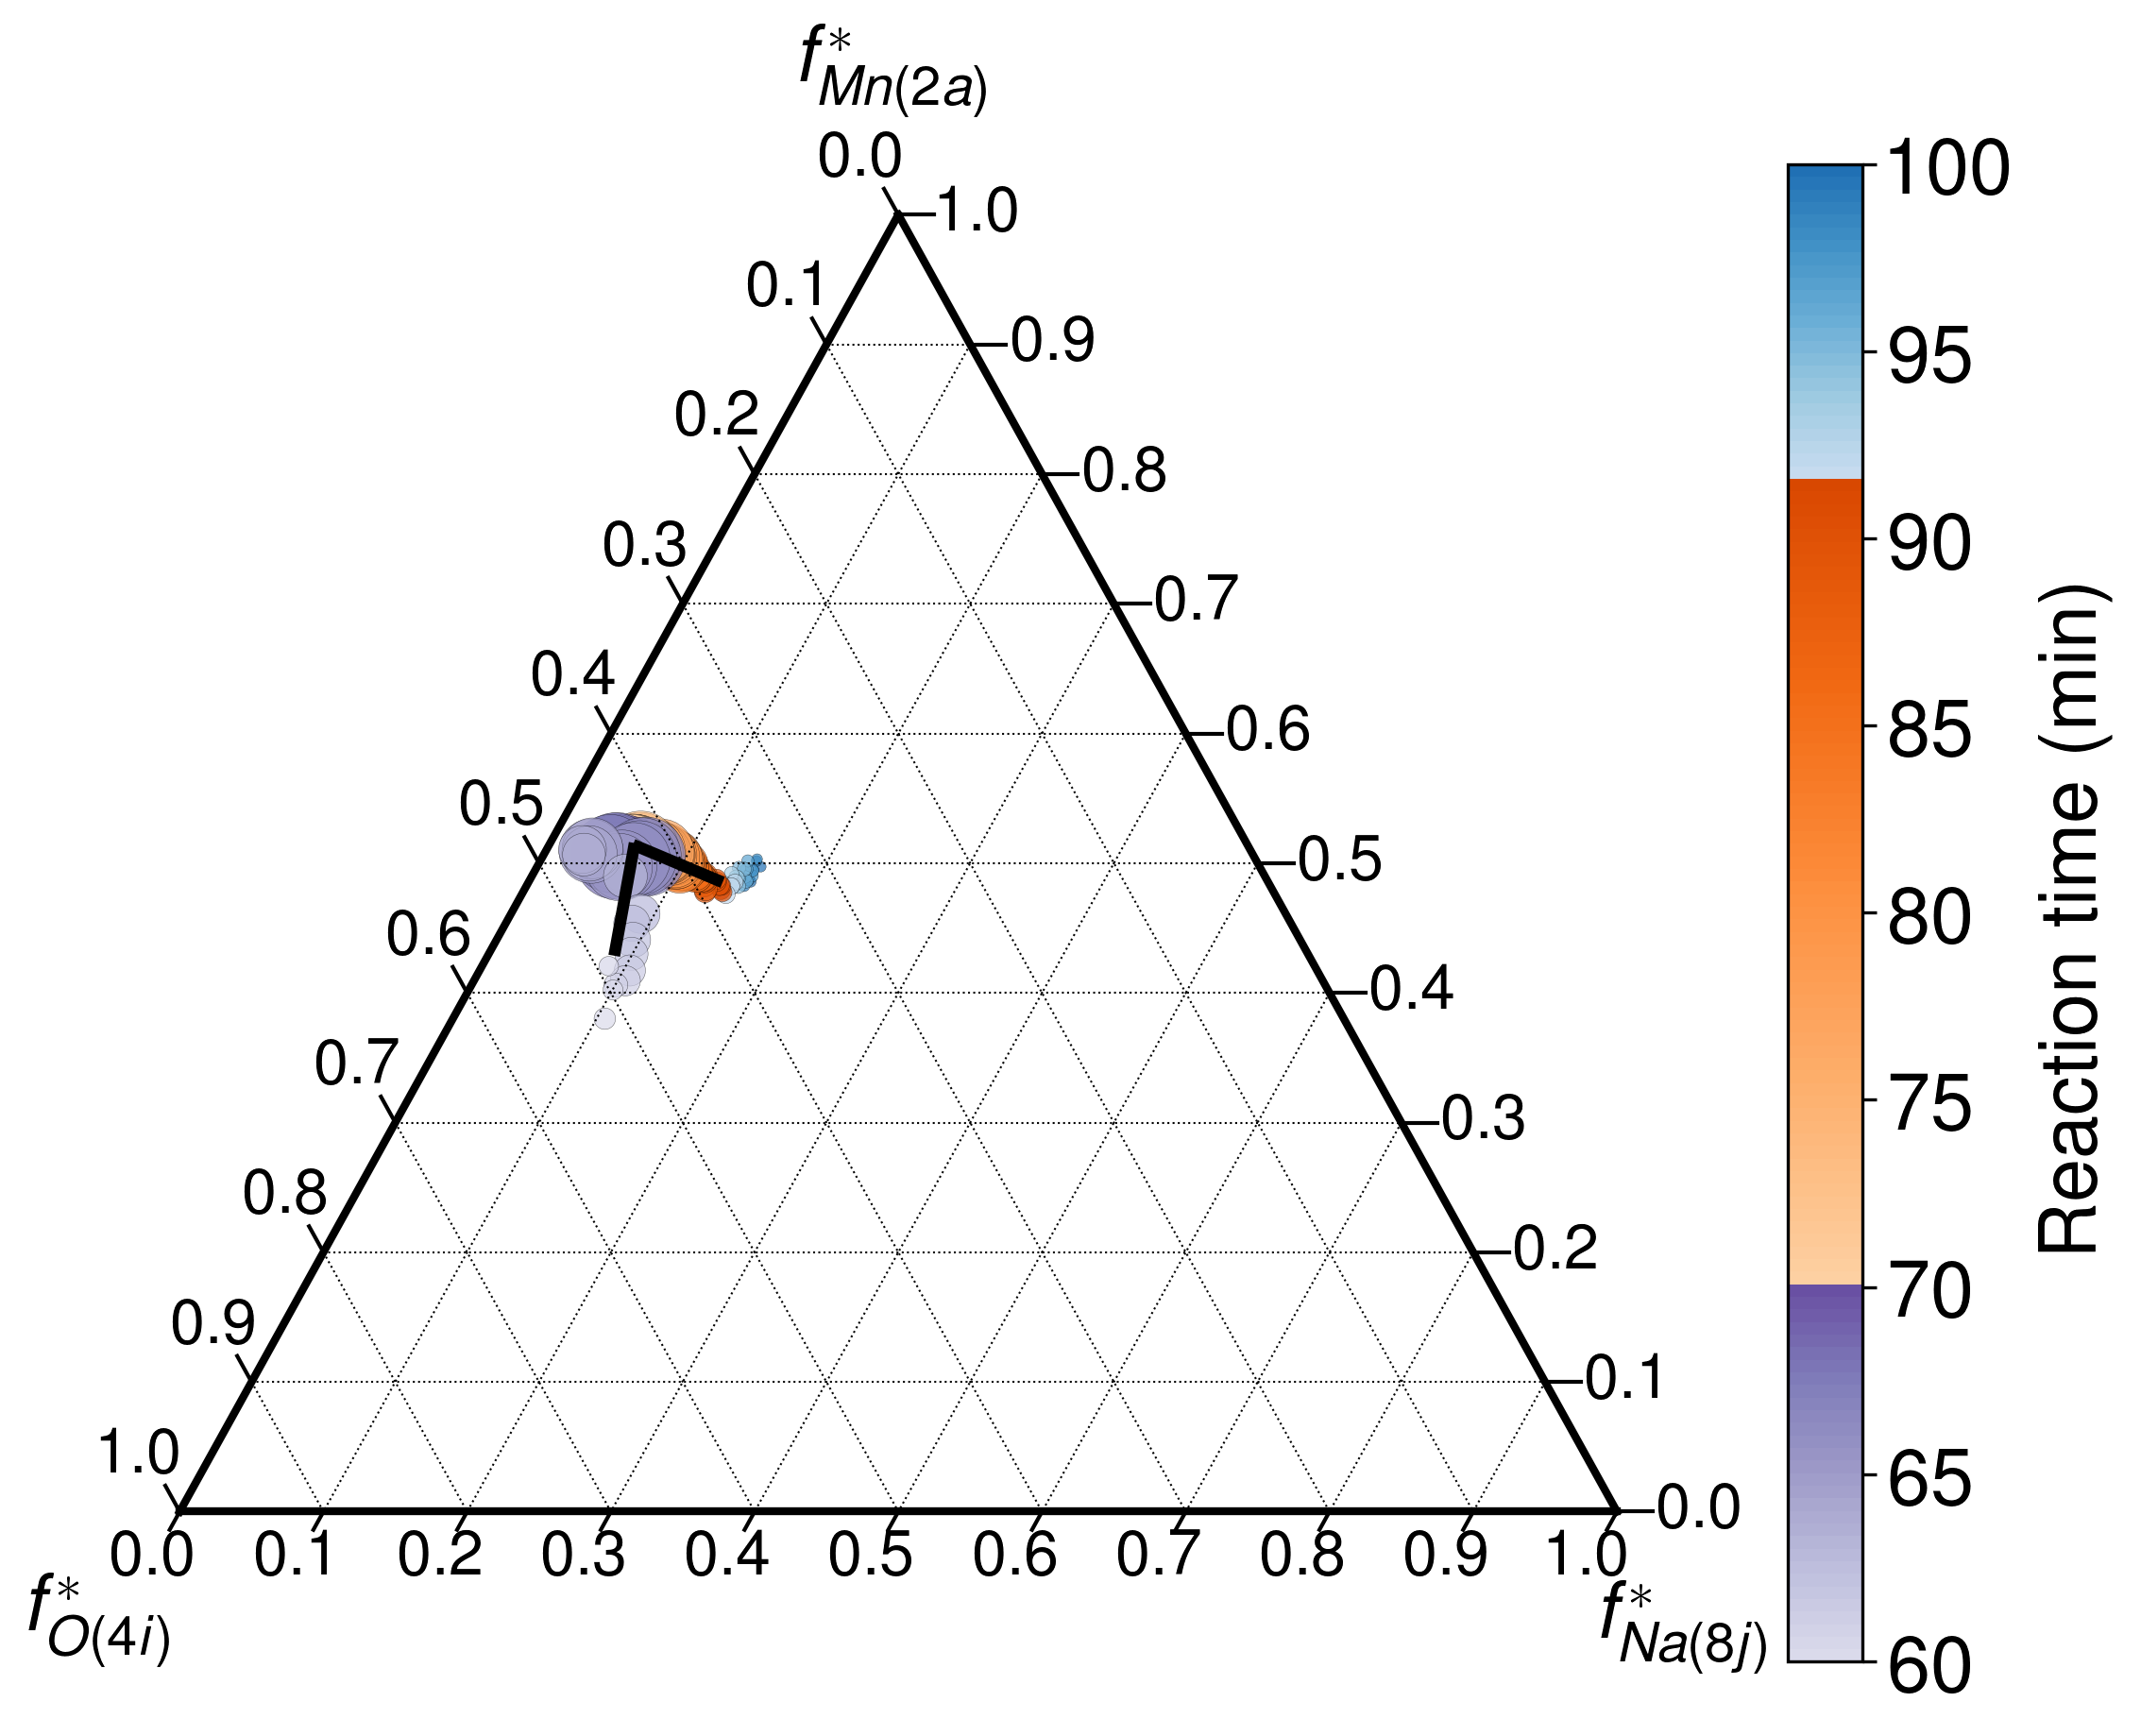

In [13]:
#f* diagrams - P3 with trajectories
colors = np.linspace(100, 60, 125)
middle = cm.get_cmap('Oranges', 256)
top = cm.get_cmap('Purples', 256)
bottom = cm.get_cmap('Blues', 256)

newcolors = np.vstack((top(np.linspace(0.25,0.75,30)), middle(np.linspace(0.25, 0.75, 64)), bottom(np.linspace(0.25, 0.75, 25))))
newcmp = ListedColormap(newcolors, name='Test')
#colors = dataP3['time']
colors2 = colors[0:10]
#marker size
area = 3.14*(2*(WSF_P310[::-1]))**3
#'#ffcc5c'

# colors = np.linspace(0.,60, 209)

#cmap = mpl.colors.ListedColormap(['#4040a1', '#ffef96', '#ff6f69'])
#bounds = [57.66, 64, 85, 127.66]
#norm = mpl.colors.BoundaryNorm(bounds, newcmp.N)

#cb_kwargs = {"boundaries" : bounds, "spacing": "proportional"}
dots = 'Black'
mark= 'D'
fontsize = 20
offset = 0.14
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(9, 7)
#ax= figure.add_axes([0.95, 0.15, 0.04, 0.75])
#cb2 = mpl.colorbar.ColorbarBase(ax, cmap=newcmp,norm=norm, ticks=bounds,spacing='proportional', orientation='vertical')
#cb2.set_label('Reaction time (min)')
#cb = tax.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap)
# Plot a few different styles with a legend
tax.scatter(points_P3[::-1], c=colors, vmin=min(colors),vmax=max(colors),colormap=newcmp, s=area, alpha=0.7, edgecolors='black',colorbar=True, cbarlabel='Reaction time (min)', cmap=newcmp, linewidths=0.1, label='WSF P2-Na$_x$MnO$_2$')
# tax.scatter(MnO2, marker='s', color='teal', linewidth=3, label='MnO$_2$')
# tax.scatter(NaMn2O4, marker='s', color='cyan', linewidth=3, label='NaMn$_2$O$_4$')
# tax.scatter(NaMnO2, marker='s', color='lime', linewidth=3, label='NaMnO$_2$')
# tax.plot(points_CS, color='red')
# tax.plot(points_CV, color='red')
#tax.scatter(Mn2O3, marker='v', color='green', linewidth=3, label='Mn$_2$O$_3$')
#tax.scatter(NaMn3O8, marker='v', color='lime', linewidth=3, label='NaMn$_3$O$_8$')
#tax.scatter(NaMnO4, marker='v', color='olive', linewidth=3, label='NaMnO$_4$')
#tax.label(8.5, 0.8, 'LiMn$_2$O$_4$', color='orange')
#[::-1]

### Cation swapping:
numpoints=5
Na_start=0.1
Na_stop=0.02
Mn_start=0.79
Mn_stop=1
Mn_Na_start = 0.0
Mn_Na_stop=0.0
Na=np.linspace(Na_start,Na_stop,numpoints)
Mn=np.linspace(Mn_start,Mn_stop,numpoints)
Mn_Na = np.linspace(Mn_Na_start,Mn_Na_stop,numpoints)
O=np.linspace(1,1.1,51)
fNa=(Na*8*AFFNa)+(Mn_Na*2*AFFMn)
fMn=Mn*AFFMn*2
fO=4*AFFO*O

fs_swap=np.zeros([len(fNa),3])
for ii in range(0,len(fNa)):
    fs_swap[ii,0] = fNa[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_swap[ii,1] = fMn[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_swap[ii,2] = fO[ii]/(fNa[ii]+fMn[ii]+fO[ii])
#tax.scatter(fs_swap, color=dots, marker=mark)
#tax.plot(fs_swap, color=dots, linewidth=3)


### cation vacancies
numpoints=5
Na_start=0.09
Na_stop=0.07
Mn_start=0.79
Mn_stop=1.04
Mn_Na_start = 0.0
Mn_Na_stop=0.0
Na=np.linspace(Na_start,Na_stop,numpoints)
Mn=np.linspace(Mn_start,Mn_stop,numpoints)
Mn_Na = np.linspace(Mn_Na_start,Mn_Na_stop,numpoints)
O=np.linspace(1.1,1.04,51)
fNa=(Na*8*AFFNa)
fMn=Mn*AFFMn*2
fO=4*AFFO*O


fs_vac=np.zeros([len(fNa),3])
for ii in range(0,len(fNa)):
    fs_vac[ii,0] = fNa[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_vac[ii,1] = fMn[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_vac[ii,2] = fO[ii]/(fNa[ii]+fMn[ii]+fO[ii])
#tax.scatter(fs_vac, color=dots, marker=mark)
tax.plot(fs_vac, color=dots, linewidth=3)


### Na vacancies
numpoints=51
Na_start=0.07
Na_stop=0.11
Mn_start=1
Mn_stop=0.72
Mn_Na_start = 0.0
Mn_Na_stop=0.0
Na=np.linspace(Na_start,Na_stop,numpoints)
Mn=np.linspace(Mn_start,Mn_stop,numpoints)
Mn_Na = np.linspace(Mn_Na_start,Mn_Na_stop,numpoints)
O=np.linspace(1.04,0.71,51)
fNa=(Na*8*AFFNa)+(Mn_Na*8*AFFMn)
fMn=Mn*AFFMn*2
fO=4*AFFO*O


fs_Navac=np.zeros([len(fNa),3])
for ii in range(0,len(fNa)):
    fs_Navac[ii,0] = fNa[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_Navac[ii,1] = fMn[ii]/(fNa[ii]+fMn[ii]+fO[ii])
    fs_Navac[ii,2] = fO[ii]/(fNa[ii]+fMn[ii]+fO[ii])
#tax.scatter(fs_Navac, color=dots, marker=mark)
tax.plot(fs_Navac, color=dots, linewidth=3)



#tax.legend()
tax.left_corner_label("$f^{*}_{O(4i)}$", fontsize=20, offset=0.01)
tax.top_corner_label("$f^{*}_{Mn(2a)}$", fontsize=20)
tax.right_corner_label("$f^{*}_{Na(8j)}$", fontsize=20, offset=0)

#tax.set_title("f* maps for NaMnO$_2$", fontsize=20)
tax.boundary()
tax.gridlines(multiple=0.1, color="black")
tax.ticks(axis='l', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=16, offset=0.02)
tax.ticks(axis='b', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=16, offset=0.014
         )
tax.ticks(axis='r', linewidth=1, multiple=0.1, tick_formats="%.1f", fontsize=16, offset=0.025)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.show()
tax.savefig('/Applications/TeX/Documents/Na2CO3_AssistedMetathesis/fstar_trajectories_P3.png', dpi=300)

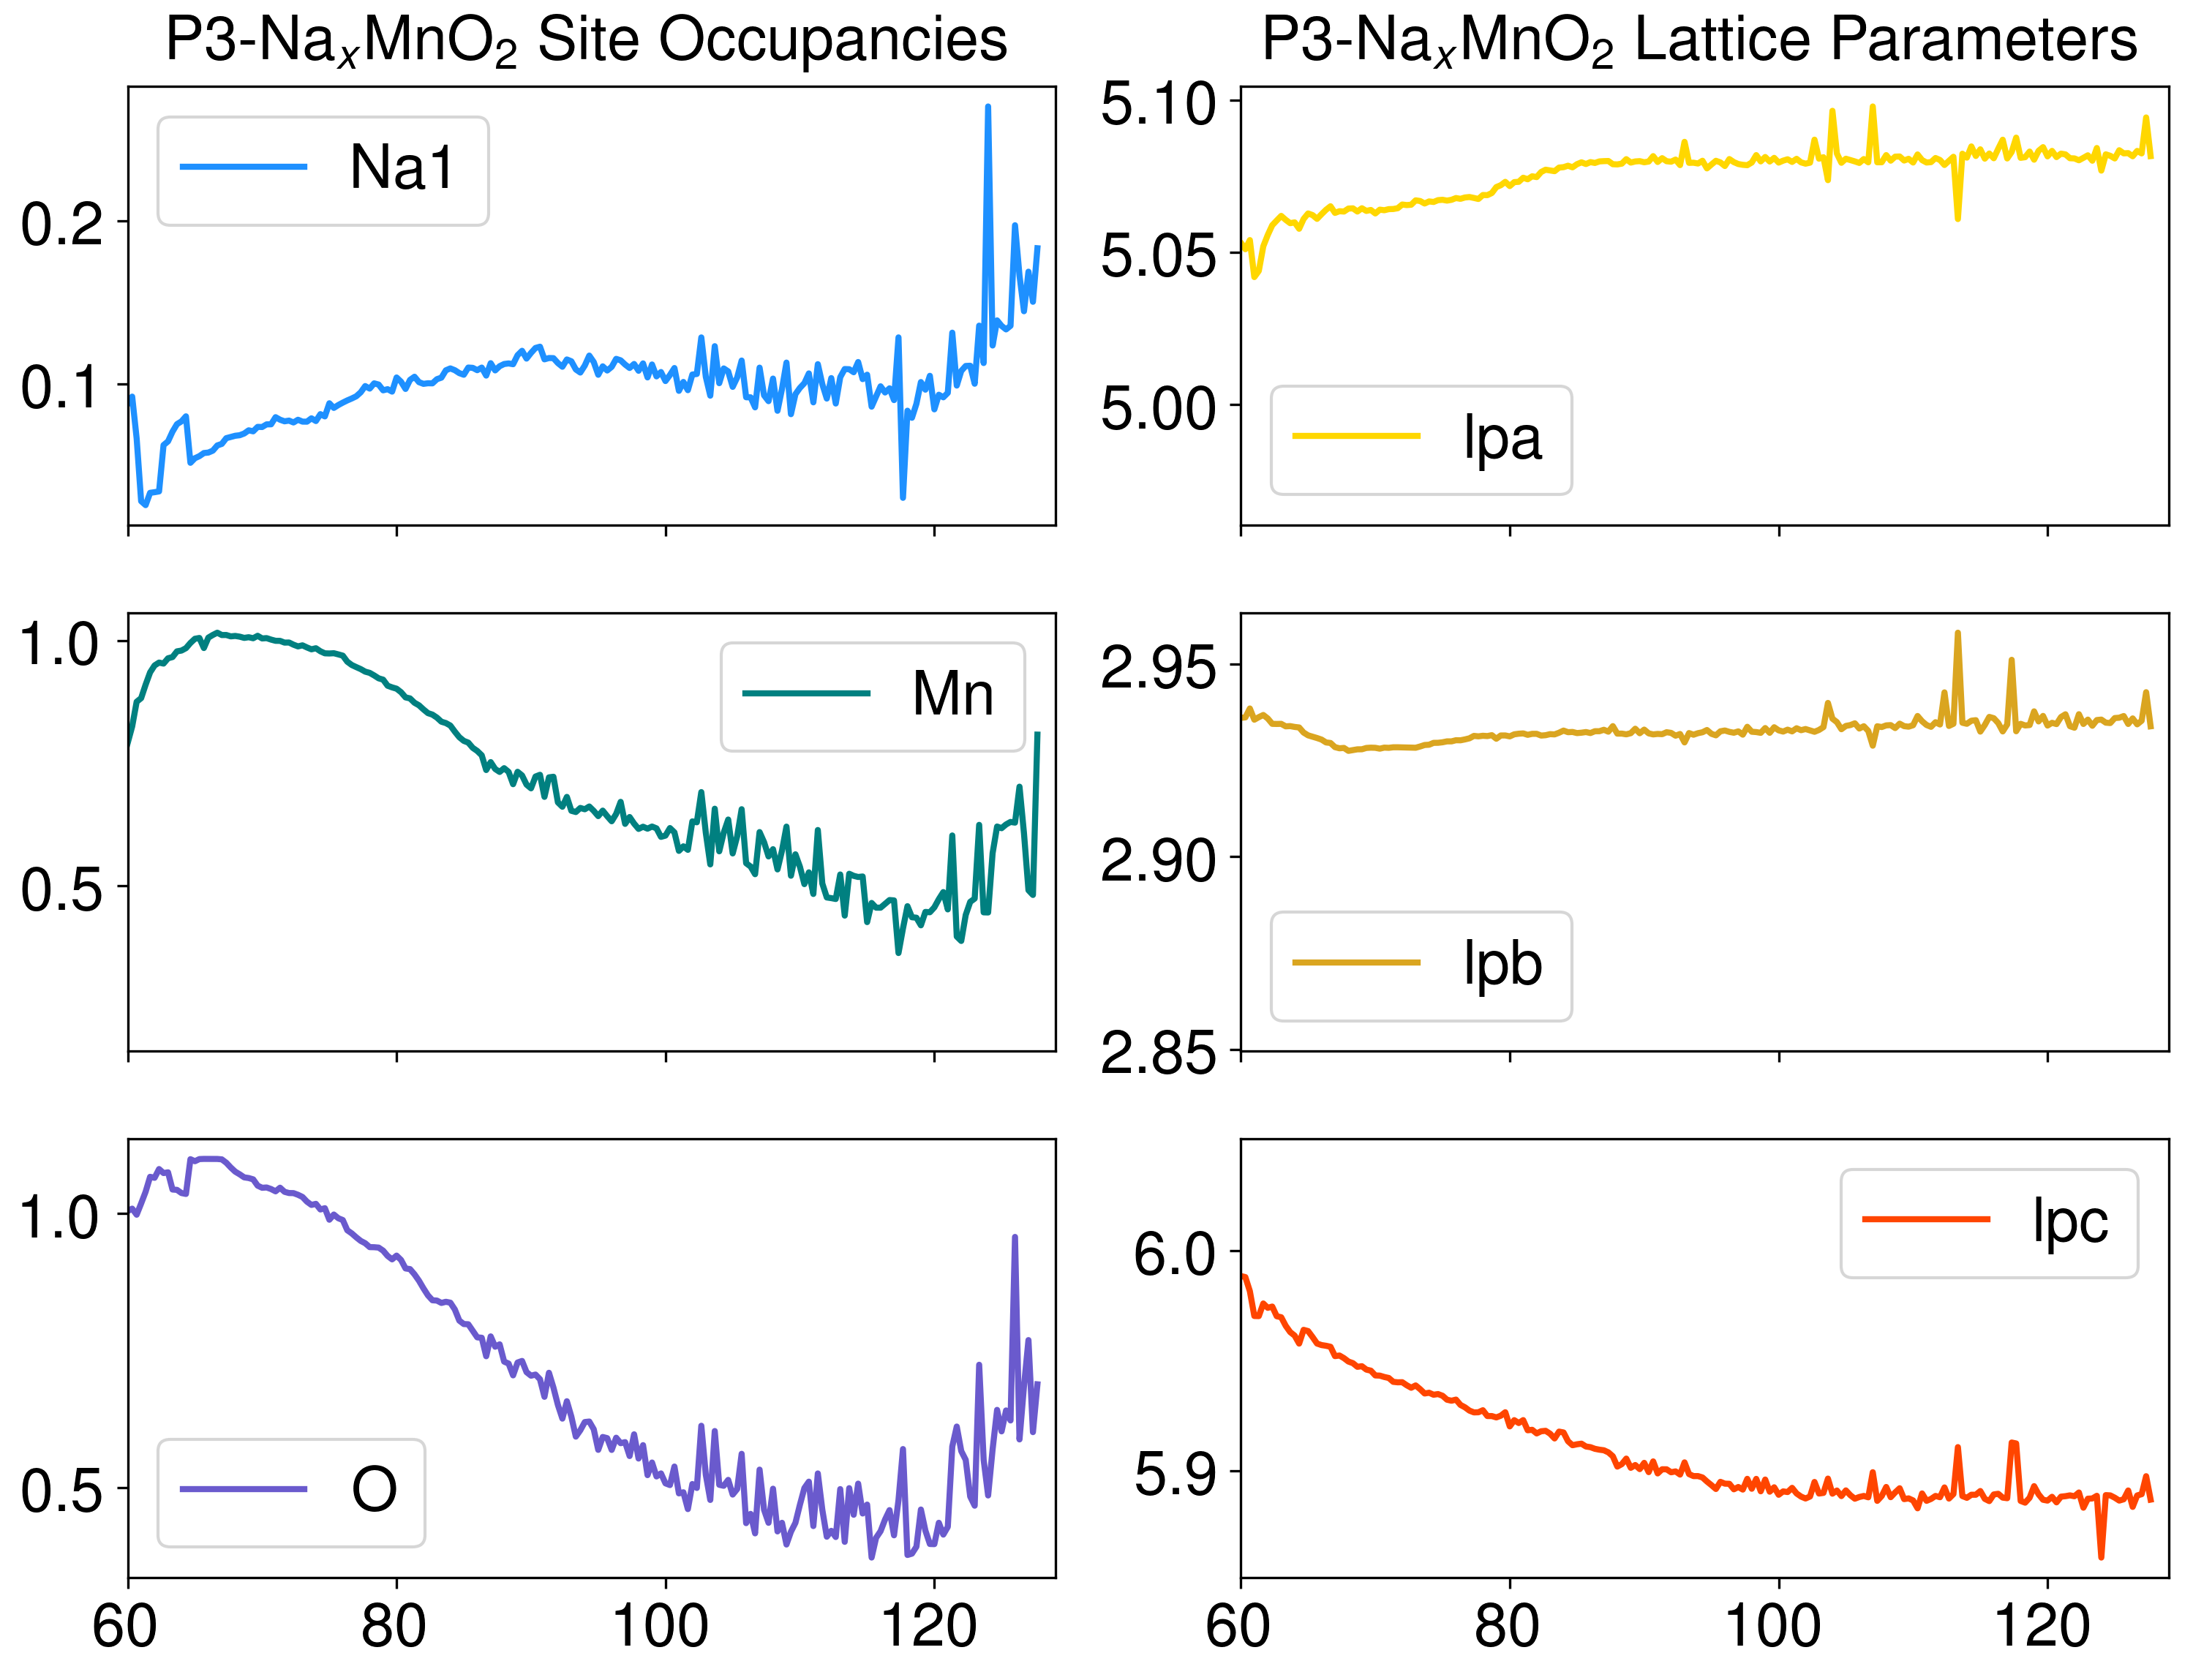

In [109]:
#Parameters for P3

fig, axs = plt.subplots(3,2, figsize=(12,9), sharex=True)

axs[0,0].plot(Time,P3Na, color='dodgerblue', label='Na1')

axs[0,1].plot(Time,a_P3, color='gold', label='lpa')
axs[1,0].plot(Time,P3Mn, color='teal', label='Mn')
axs[1,1].plot(Time,b_P3, color='goldenrod', label='lpb')
axs[2,0].plot(Time,P3O, color='slateblue', label='O')
axs[2,1].plot(Time,c_P3, color='orangered', label='lpc')
axs[0,0].set_xlim(60,129)
axs[0,0].set_title('P3-Na$_x$MnO$_2$ Site Occupancies')
axs[0,1].set_title('P3-Na$_x$MnO$_2$ Lattice Parameters')
axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[2,1].legend()
axs[2,0].legend()

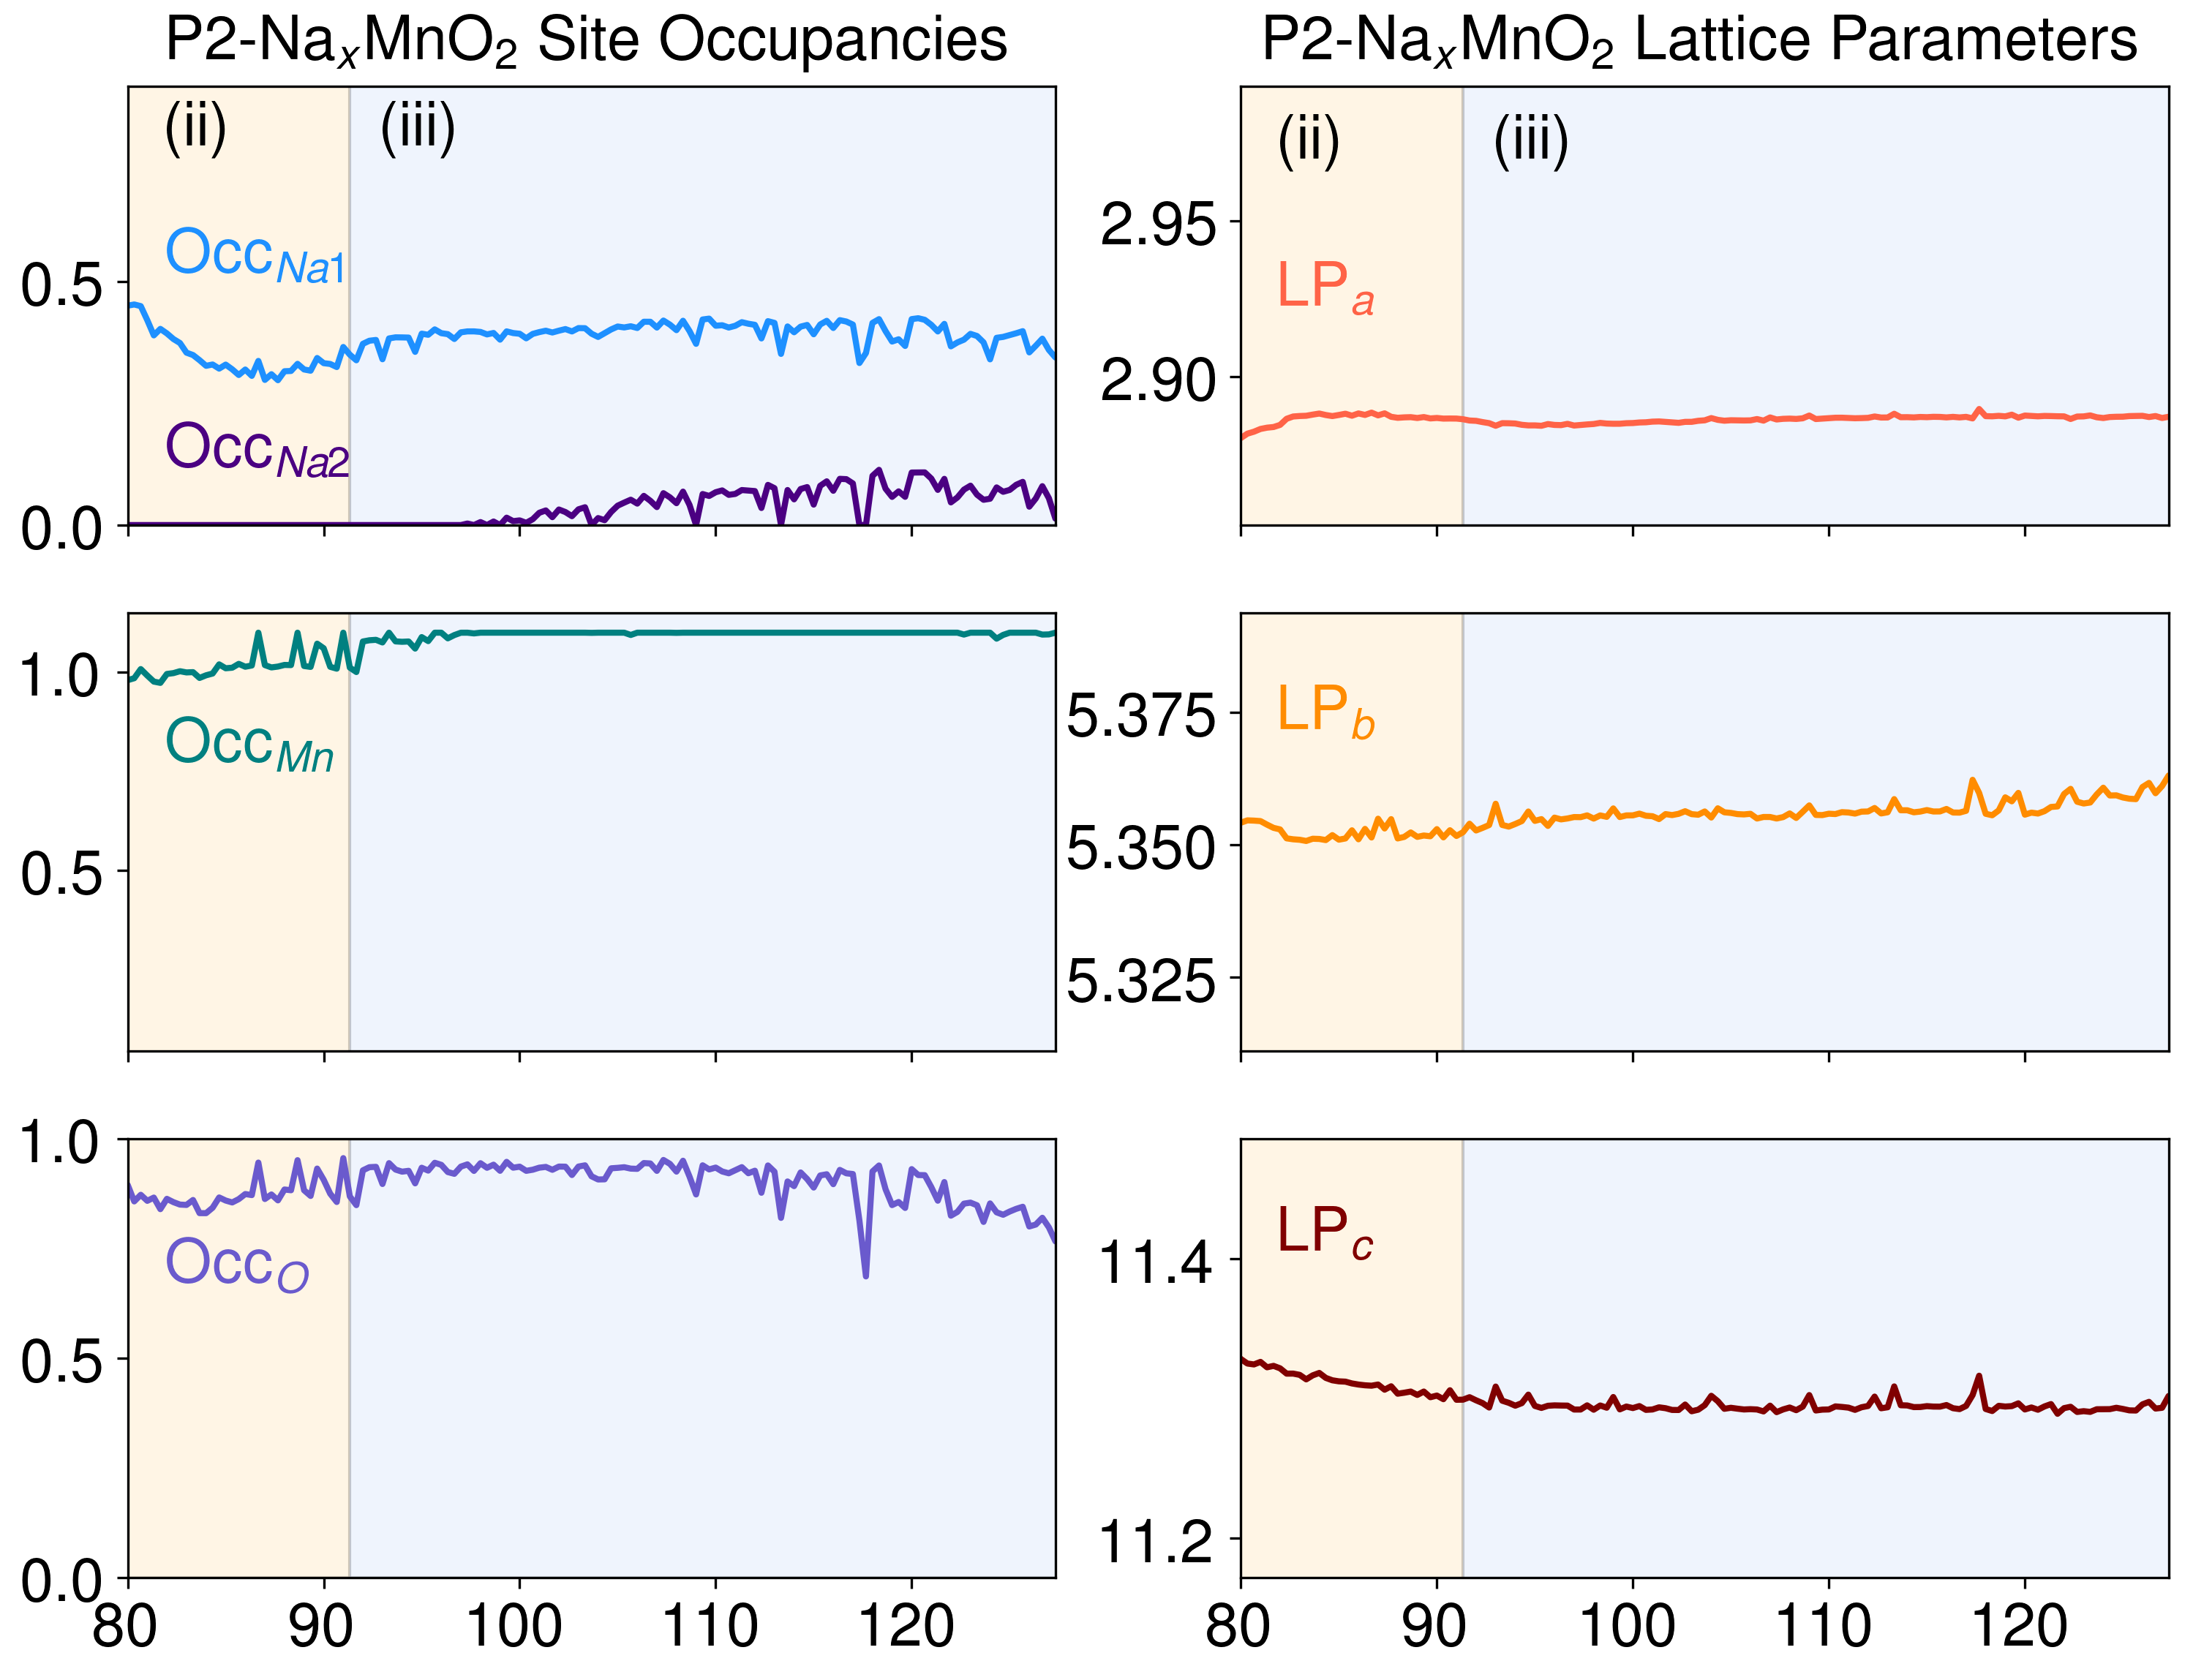

In [129]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,9), sharex=True)
#axes [0,0] Sodium Occupancy
rectangle1 = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangle2 = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectangle3 = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
Na1Occ = axes[0,0].plot(Time, P2Na1,  color='dodgerblue')
Na2Occ = axes[0,0].plot(Time, P2Na2, color='indigo')
axes[0,0].text(82, 0.5, 'Occ$_{Na1}$', color='dodgerblue')
axes[0,0].text(82, 0.1, 'Occ$_{Na2}$', color='Indigo')
axes[0,0].add_patch(rectangle1)
axes[0,0].add_patch(rectangle2)
axes[0,0].add_patch(rectangle3)
#axes[0,0].text(59.5, 0.78, '(i)', color='black')
axes[0,0].text(82, 0.78, '(ii)', color='black')
axes[0,0].text(93, 0.78, '(iii)', color='black')
axes[0,0].set_xlim(80, 127.33)
axes[0,0].set_ylim(0, 0.9)


#axes [1,0] Manganese Occupancy
rectangle3 = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangle4 = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectangle5 = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
MnOcc = axes[1,0].plot(Time, P2Mn,  color='teal')
axes[1,0].text(82, 0.75, 'Occ$_{Mn}$', color='teal')
axes[1,0].add_patch(rectangle3)
axes[1,0].add_patch(rectangle4)
axes[1,0].add_patch(rectangle5)
axes[1,0].set_xlim(80, 127.33)

#axes [2,0] Oxygen Occupancy
rectangle6 = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangle7 = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectangle8 = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
OOcc = axes[2,0].plot(Time, P2O,  color='slateblue')
axes[2,0].text(82, 0.65, 'Occ$_{O}$', color='slateblue')
axes[2,0].add_patch(rectangle6)
axes[2,0].add_patch(rectangle7)
axes[2,0].add_patch(rectangle8)
axes[2,0].set_xlim(80, 127.33)
axes[2,0].set_ylim(0, 1)

#axes [0,1] Lattice parameter a
rectanglea = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangleb = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectanglec = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
LPa = axes[0,1].plot(Time, a_P2,  color='tomato')
axes[0,1].text(82, 2.92, 'LP$_a$', color='tomato')
axes[0,1].add_patch(rectanglea)
axes[0,1].add_patch(rectangleb)
axes[0,1].add_patch(rectanglec)
axes[0,1].set_xlim(80, 127.33)
#axes[0,1].text(60.5, 2.8835, '(i)', color='black')
axes[0,1].text(82, 2.97, '(ii)', color='black')
axes[0,1].text(93, 2.97, '(iii)', color='black')

#axes [1,1] lpb
rectangled = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectanglee = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectanglef = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
LPb = axes[1,1].plot(Time, b_P2,  color='darkorange')
axes[1,1].text(82, 5.37, 'LP$_{b}$', color='darkorange')
axes[1,1].add_patch(rectangled)
axes[1,1].add_patch(rectanglee)
axes[1,1].add_patch(rectanglef)
axes[1,1].set_xlim(80, 127.33)

#axes [2,1] lpc
rectangleg = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangleh = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectanglei = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
LPc = axes[2,1].plot(Time, c_P2,  color='maroon')
axes[2,1].text(82, 11.40, 'LP$_{c}$', color='maroon')
axes[2,1].add_patch(rectangleg)
axes[2,1].add_patch(rectangleh)
axes[2,1].add_patch(rectanglei)
axes[2,1].set_xlim(80, 127.33)

axes[0,0].set_title('P2-Na$_x$MnO$_2$ Site Occupancies')
axes[0,1].set_title('P2-Na$_x$MnO$_2$ Lattice Parameters')

#a_1 = Index_All_5beq.plot(y='lpa', color='gold', ax=axes[0,1], legend=True, title='B. Lattice Parameters')
#b_1 = Index_All_5beq.plot(y='lpb', color='goldenrod', ax=axes[1,1], legend=True)
#O = Index_All_5beq.plot(y='OccO', color='slateblue', ax=axes[2,0], legend=True)
#c_1 = Index_All_5beq.plot(y='lpc', color='orangered', ax=axes[2,1], legend=True)

#Na1.text(58, 95, '(i)', color='black')
#Na1.text(65, 95, '(ii)', color='black')
#Na1.text(86, 95, '(iii)', color='black')


plt.savefig('/Applications/TeX/Documents/Na2CO3_AssistedMetathesis/parameters_P2.png', dpi=300)




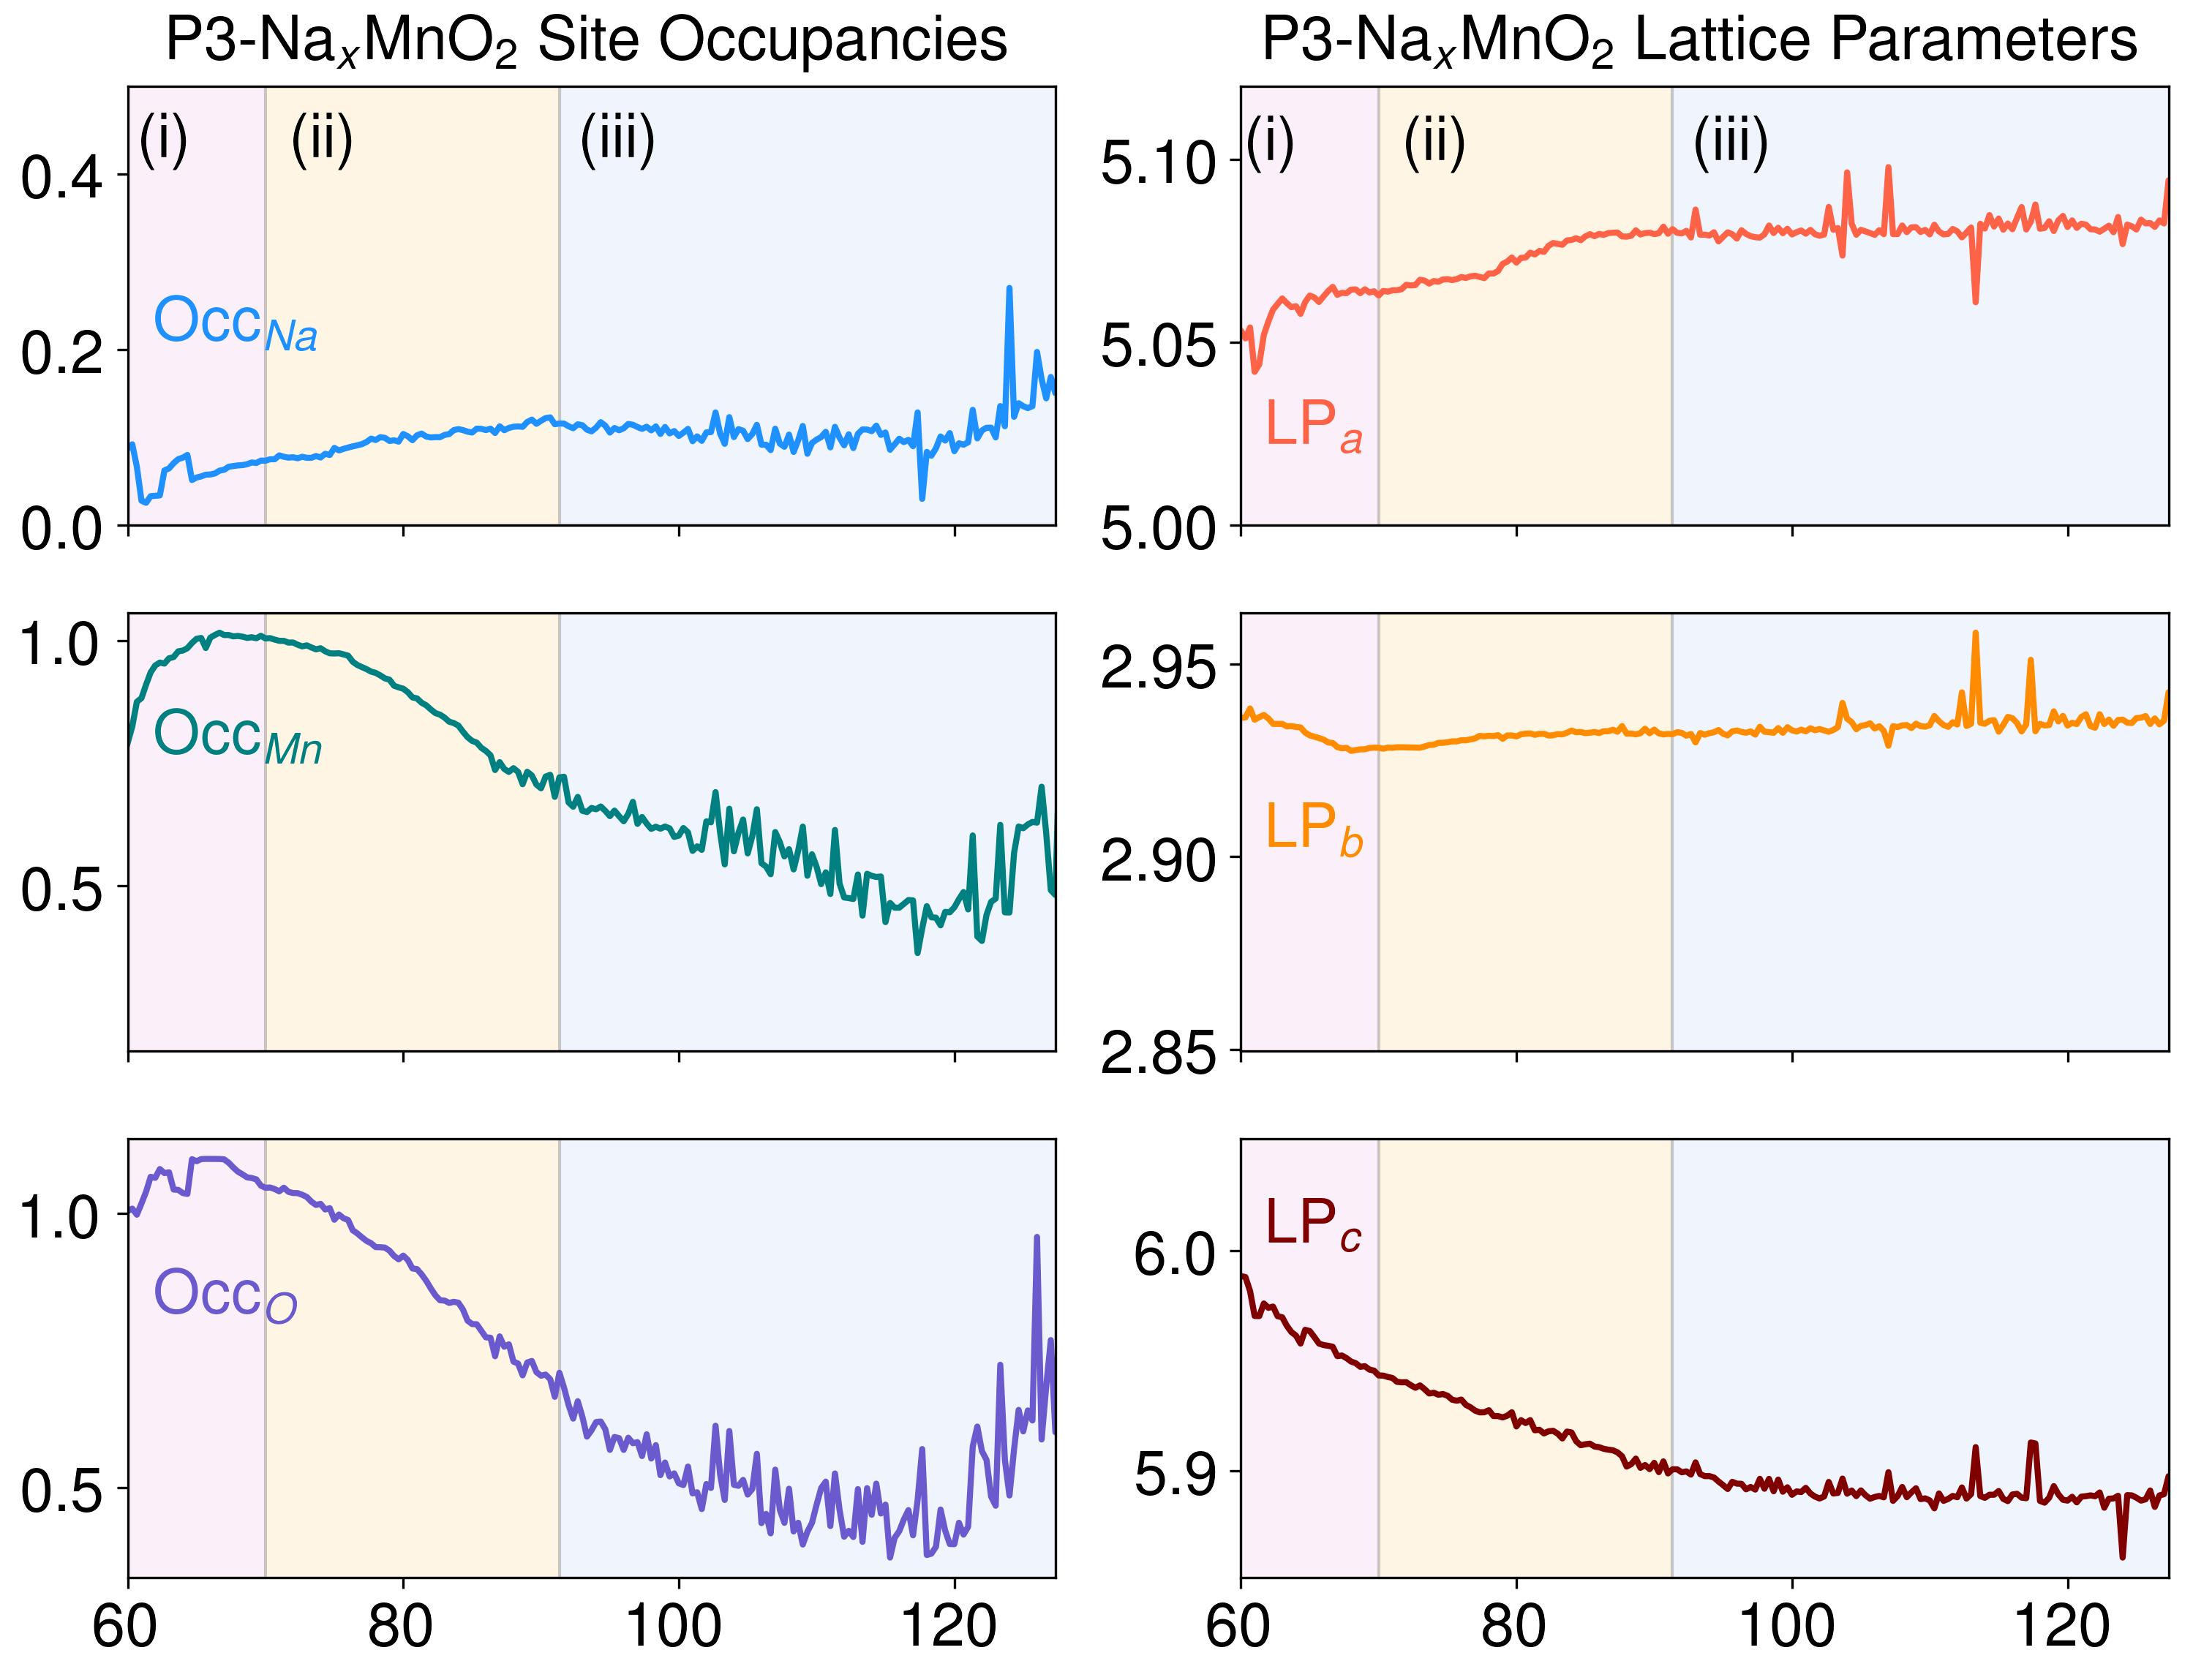

In [139]:
#P3 with rectangles

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,9), sharex=True)
#axes [0,0] Sodium Occupancy
rectangle1 = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangle2 = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectangle3 = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
Na1Occ = axes[0,0].plot(Time, P3Na,  color='dodgerblue')
axes[0,0].text(62, 0.2, 'Occ$_{Na}$', color='dodgerblue')
axes[0,0].add_patch(rectangle1)
axes[0,0].add_patch(rectangle2)
axes[0,0].add_patch(rectangle3)
axes[0,0].text(61, 0.42, '(i)', color='black')
axes[0,0].text(72, 0.42, '(ii)', color='black')
axes[0,0].text(93, 0.42, '(iii)', color='black')
axes[0,0].set_xlim(60, 127.33)
axes[0,0].set_ylim(0, 0.5)


#axes [1,0] Manganese Occupancy
rectangle3 = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangle4 = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectangle5 = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
MnOcc = axes[1,0].plot(Time, P3Mn,  color='teal')
axes[1,0].text(62, 0.75, 'Occ$_{Mn}$', color='teal')
axes[1,0].add_patch(rectangle3)
axes[1,0].add_patch(rectangle4)
axes[1,0].add_patch(rectangle5)
axes[1,0].set_xlim(60, 127.33)

#axes [2,0] Oxygen Occupancy
rectangle6 = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangle7 = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectangle8 = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
OOcc = axes[2,0].plot(Time, P3O,  color='slateblue')
axes[2,0].text(62, 0.8, 'Occ$_{O}$', color='slateblue')
axes[2,0].add_patch(rectangle6)
axes[2,0].add_patch(rectangle7)
axes[2,0].add_patch(rectangle8)
axes[2,0].set_xlim(60, 127.33)
#axes[2,0].set_ylim(0, 1)

#axes [0,1] Lattice parameter a
rectanglea = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangleb = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectanglec = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
LPa = axes[0,1].plot(Time, a_P3,  color='tomato')
axes[0,1].text(62, 5.02, 'LP$_a$', color='tomato')
axes[0,1].add_patch(rectanglea)
axes[0,1].add_patch(rectangleb)
axes[0,1].add_patch(rectanglec)
axes[0,1].set_xlim(60, 127.33)
axes[0,1].text(60.5, 5.1, '(i)', color='black')
axes[0,1].text(72, 5.1, '(ii)', color='black')
axes[0,1].text(93,5.1, '(iii)', color='black')
axes[0,1].set_ylim(5, 5.12)

#axes [1,1] lpb
rectangled = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectanglee = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectanglef = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
LPb = axes[1,1].plot(Time, b_P3,  color='darkorange')
axes[1,1].text(62, 2.9, 'LP$_{b}$', color='darkorange')
axes[1,1].add_patch(rectangled)
axes[1,1].add_patch(rectanglee)
axes[1,1].add_patch(rectanglef)
axes[1,1].set_xlim(60, 127.33)

#axes [2,1] lpc
rectangleg = plt.Rectangle((60, 0), 10, 16, edgecolor='black', facecolor='orchid', alpha=0.1)
rectangleh = plt.Rectangle((70, 0), 21.33, 91.33, edgecolor='black', facecolor='orange', alpha=0.1)
rectanglei = plt.Rectangle((91.33, 0), 42.66, 16, edgecolor='black', facecolor='CornflowerBlue', alpha=0.1)
LPc = axes[2,1].plot(Time, c_P3,  color='maroon')
axes[2,1].text(62, 6.0, 'LP$_{c}$', color='maroon')
axes[2,1].add_patch(rectangleg)
axes[2,1].add_patch(rectangleh)
axes[2,1].add_patch(rectanglei)
axes[2,1].set_xlim(60, 127.33)

axes[0,0].set_title('P3-Na$_x$MnO$_2$ Site Occupancies')
axes[0,1].set_title('P3-Na$_x$MnO$_2$ Lattice Parameters')

#a_1 = Index_All_5beq.plot(y='lpa', color='gold', ax=axes[0,1], legend=True, title='B. Lattice Parameters')
#b_1 = Index_All_5beq.plot(y='lpb', color='goldenrod', ax=axes[1,1], legend=True)
#O = Index_All_5beq.plot(y='OccO', color='slateblue', ax=axes[2,0], legend=True)
#c_1 = Index_All_5beq.plot(y='lpc', color='orangered', ax=axes[2,1], legend=True)

#Na1.text(58, 95, '(i)', color='black')
#Na1.text(65, 95, '(ii)', color='black')
#Na1.text(86, 95, '(iii)', color='black')


plt.savefig('/Applications/TeX/Documents/Na2CO3_AssistedMetathesis/parameters_P3.png', dpi=300)


